In [1]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer as MICE
import numpy as np
from sklearn.linear_model import LinearRegression
import pandas as pd
from sklearn.preprocessing import StandardScaler
import re
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import matplotlib.ticker as mtick
from scipy import stats


c:\Users\Giuse\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
import os
import pandas as pd

def standardize_col_names(df):
    # Standardize column names: remove spaces, dashes, convert to lowercase
    df.columns = df.columns.str.strip().str.replace(' ', '').str.replace('-', '').str.lower()
    
    # Handle encoding issues: Replace problematic characters
    df.columns = df.columns.str.replace('’', "'")  # Replace right single quotation mark with apostrophe
    
    # Standardize specific columns based on the provided mappings
    col_mapping = {
        'investmenttype': 'InvestmentType',
        'city/location': 'City',
        'city': 'City',
        '2': 'City',
        '0': 'StartupName',
        'startupname': 'StartupName',
        '3': 'IndustryVertical',
        'industryvertical': 'IndustryVertical',
        'industry/vertical': 'IndustryVertical',
        '5': 'InvestorName',
        'investorsname': 'InvestorName',
        'investorname': 'InvestorName',
        '7': 'Amount(inUSD)',
        'amount(inusd)': 'Amount(inUSD)',
        'amountinusd': 'Amount(inUSD)',
        '8': 'InvestmentStage',
        'remarks': 'InvestmentStage',
        'investmentstage': 'InvestmentStage',
        '4': 'SubVertical',
        'sub-vertical': 'SubVertical',
        '6': 'Investors',
        'investors': 'Investors'
    }
    
    # Rename the columns based on the mapping
    df.rename(columns={old: new for old, new in col_mapping.items() if old in df.columns}, inplace=True)

    return df

# Define the root directory containing the datasets
root_dir = 'C:\\Bayes Business School\\Digital Technologies & Value Creation\\Datasets\\StartUp_FundingScrappingData'

# Initialize an empty list to store dataframes
dataframes = []
  
# Walk through the directory to find and process all CSV files
for subdir, dirs, files in os.walk(root_dir):
    for file in files:
        if file.endswith(".csv"):  # Check if the file is a CSV
            file_path = os.path.join(subdir, file)
            if file_path.endswith('.csv'):
                df = pd.read_csv(file_path)
            try:
                df = pd.read_csv(file_path, encoding='utf-8')  # Handle encoding
                df = standardize_col_names(df)
                dataframes.append(df)
            except Exception as e:
                print(f"Failed to process {file_path}: {e}")

# Concatenate all dataframes into one
combined_df = pd.concat(dataframes, ignore_index=True)

# Combine the three columns into one
combined_df['Investors'] = combined_df['Investors'].combine_first(combined_df['Investors']).combine_first(combined_df['InvestorName'])

# Drop the old columns if they are no longer needed
combined_df = combined_df.drop(columns=['Investors', 'InvestorName'])

In [3]:
combined_df = combined_df.drop(columns=['date(dd/mm/yyyy)', 'date'])

In [4]:
# Get unique date values
unique_dates = combined_df['foundingdate'].unique()
unique_dates

array([nan, 2015.0, 2018.0, 2019.0, 2017.0, 2014.0, 2004.0, 2008.0,
       2011.0, 2013.0, 2016.0, 2012.0, '2017', '2018', '2014', '2011',
       '2015', '2016', '2019', '2010', '2013', '-', '2020', '2012', 2020,
       1998, 2007, 1982, 2009, 1995, 2010, 2001.0, 2002.0, 2006.0, 1978.0,
       1999.0, 1994.0, 2005.0, 1973.0, 2021, 1993, 1989, 2000, 2003, 1991,
       1984, 1963], dtype=object)

In [5]:
unique_dates_1 = combined_df['1'].unique()
unique_dates_1

array([  nan, 2015., 2019., 2014., 2010., 2017., 2018., 2012., 2016.,
       2009., 2008.])

In [6]:
# Convert the numeric year values from the column '1' to integers, handling NaN appropriately
combined_df['1_year'] = combined_df['1'].astype('float').apply(lambda x: int(x) if pd.notna(x) else x)

# Display the unique values of the new column to verify the changes
combined_df['1_year'].unique()

array([  nan, 2015., 2019., 2014., 2010., 2017., 2018., 2012., 2016.,
       2009., 2008.])

In [7]:
# Step 1: Convert all entries to strings and remove any non-numeric characters or malformed entries
combined_df['foundingdate'] = combined_df['foundingdate'].astype(str).str.extract('(\d{4})')

# Step 2: Convert the extracted strings back to integers, handling NaN appropriately
combined_df['founding_year'] = pd.to_numeric(combined_df['foundingdate'], errors='coerce')

# Display the unique values of the new column to verify the changes
combined_df['founding_year'].unique()

array([  nan, 2015., 2018., 2019., 2017., 2014., 2004., 2008., 2011.,
       2013., 2016., 2012., 2010., 2020., 1998., 2007., 1982., 2009.,
       1995., 2001., 2002., 2006., 1978., 1999., 1994., 2005., 1973.,
       2021., 1993., 1989., 2000., 2003., 1991., 1984., 1963.])

In [8]:
# Convert 'foundingdate' to datetime format
combined_df['1'] = pd.to_datetime(combined_df['1'], errors='coerce')

# Extract the year from 'foundingdate' and create a new column 'founding_year'
combined_df['1_year'] = combined_df['1'].dt.year

In [9]:
# Combining 'date_year_date', 'date_year', and 'founding_year' into a single column 'founding_year'
# Combine '1_year' into 'founding_year', prioritizing non-null values from '1_year'
combined_df['founding_year'] = combined_df['1_year'].combine_first(combined_df['founding_year'])

In [10]:
# Combining 'date_year_date', 'date_year', and 'founding_year' into a single column 'founding_year'
# Combine '1_year' into 'founding_year', prioritizing non-null values from '1_year'
combined_df['SubVertical'] = combined_df['subvertical'].combine_first(combined_df['SubVertical'])

In [11]:
combined_df = combined_df.drop(columns=['1_year', 'sr.no.','unnamed:0', 'foundingdate','1', 'subvertical'])

In [12]:
# Remove commas from the 'Amount(inUSD)' column and convert it to numeric
combined_df['Amount(inUSD)'] = pd.to_numeric(combined_df['Amount(inUSD)'].str.replace(',', ''), errors='coerce')

# Check the conversion
combined_df[['Amount(inUSD)']].head(), combined_df['Amount(inUSD)'].describe()

(   Amount(inUSD)
 0      2000000.0
 1       200000.0
 2      1000000.0
 3       120000.0
 4       165000.0,
 count    2.088000e+03
 mean     1.811288e+07
 std      1.206148e+08
 min      9.600000e+00
 25%      4.537500e+05
 50%      1.600000e+06
 75%      8.000000e+06
 max      3.900000e+09
 Name: Amount(inUSD), dtype: float64)

In [13]:
# Drop missing values contained in the StartupName column
combined_df= combined_df.dropna(subset=['StartupName'])

In [14]:
# Retrieve StartupName column as we will need it later
StartupNameCol = combined_df['StartupName']

In [15]:
combined_df['City'].unique()

array(['Bangalore', 'Gurgaon', 'Dallas / Hyderabad', 'New Delhi',
       'Hyderabad', 'Mumbai', 'Pune', 'Kolkata', 'Chennai', 'Noida',
       'Udupi', 'Vadodara', 'Bangalore / SFO', 'Chandigarh', 'Jaipur',
       'Pune / US', 'New Delhi/ Houston', 'New Delhi / US', 'Ahmedabad',
       'Hyderabad/USA', 'Goa', 'Boston', 'Singapore',
       'Bangalore / Palo Alto', 'Coimbatore', 'Mumbai / NY', nan,
       'Nagpur', 'Mumbai / Global', 'India / US', 'Kanpur', 'Udaipur',
       'Delhi', 'New Delhi / California', 'USA/India', 'Gwalior',
       'Bangalore/ Bangkok', 'Goa/Hyderabad', 'Noida / Singapore',
       'Belgaum', 'Chennai/ Singapore', 'Pune / Singapore',
       'Bangalore / San Mateo', 'New York/ India', 'Bhopal', 'US/India',
       'Gurgaon / SFO', 'Bangalore / USA', 'SFO / Bangalore', 'London',
       'Kerala', 'Indore', 'Kozhikode', 'Pune / Dubai', 'Varanasi',
       'Mumbai / UK', 'Siliguri', 'Jodhpur', 'US', 'SFO', 'USA',
       'Seattle / Bangalore', 'Pune/Seattle', 'Lucknow', 'T

The dataset contains data entry inconsistencies which can lead to multiple representations of the same location, which complicates data analysis.

The following code ensures consistency in city names by converting all text to lowercase and trimming any leading or trailing spaces. This process also involves simplifying entries that contain multiple city names separated by slashes, by keeping only the first listed city.
Moreover, the code standardizes city names by removing variations due to different case usage or extra spaces. This prevents the same city from being recognized as different entities, such as treating 'New York', 'new york', and 'New York ' as distinct values.
We select only the first city in entries with multiple cities (split by slashes), to reduce the complexity of the data, making it more manageable for analysis that requires a single primary location per entry.

In [16]:
def standardise_city_names(x):
    if isinstance(x, str):
        x = x.lower()  # Convert to lowercase to avoid duplicate entries
        if '/' in x:
            return x.split('/')[0].strip()  # Return the first city if multiple are listed, trimmed of spaces
        else:
            return x.strip()  # Trim spaces to reduce duplicate cities
    else:
        return x  # If x is not a string, return it unchanged

combined_df['City'] = combined_df['City'].apply(standardise_city_names)

I designed the function clean_and_filter_city_names below to enhance the quality of city name column within the dataset by correcting inconsistencies, misspellings and erroneous entries.
Essentially, it checks for and preserves missing data points (NaN), ensuring that these are not mistakenly processed or altered.The function converts all city names to lowercase and removes any surrounding whitespace, creating a uniform format across the dataset. I created a dictionary so that the function maps incorrect or varied spellings of city names to a standardized correct form. It also removes entries that are not city names, replacing them with NaN.
Additionally for city names not specified in the dictionary, it formats them in title case, providing a consistent appearance.


In [17]:
def clean_and_filter_city_names(city):
    if pd.isna(city):
        return np.nan  # Return NaN for missing values
    city = city.strip().lower()
    corrections = {
        'bangalore': 'Bengaluru',
        'gurgaon': 'Gurugram',
        'ahemadabad': 'Ahmedabad',
        'ahemdabad': 'Ahmedabad',
        'kolkatta': 'Kolkata',
        'trivandrum': 'Thiruvananthapuram',
        'cochin': 'Kochi',
        'bangaldesh': 'Bangladesh',
        'san franciscao': 'San Francisco',
        'hyderebad': 'Hyderabad',
        'delhi & cambridge': 'Delhi',
        'bengaluru and gurugram': 'Bengaluru',
        'noidaedtechit is alearning platform for kids in the age group 5 to 14 yrsishan gupta': np.nan,
        'rajastan': 'Rajasthan',
        'orissia': 'Odisha',
        'telugana': 'Telangana',
        'ahmadabad': 'Ahmedabad',
        'bhubneswar': 'Bhubaneswar',
        'nw delhi': 'New Delhi',
        'kerala': 'Kerala',  # Including as a valid entry
        'gujarat': 'Gujarat',  # Including as a valid entry
        'haryana': 'Haryana',  # Including as a valid entry
        'karnataka': 'Karnataka',  # Including as a valid entry
        'jharkhand': 'Jharkhand',  # Including as a valid entry
        'india': 'India',  # Including as a valid entry
        'usa': 'USA',  # Including as a valid entry
        'us': 'USA',  # Standardizing to 'USA'
        'computer games': np.nan,  # Not a city
        'food & beverages': np.nan,  # Not a city
        'pharmaceuticals': np.nan,  # Not a city
        'information technology & services': np.nan,  # Not a city
        'online media': np.nan,  # Not a city
        'small towns': np.nan  # Ambiguous, not a specific city
    }
    return corrections.get(city, city.title())

# Assuming combined_df is your DataFrame
combined_df['City'] = combined_df['City'].apply(clean_and_filter_city_names)

# Display the cleaned data
print(sorted(combined_df['City'].dropna().unique()))

['Agra', 'Ahmedabad', 'Ambernath', 'Amritsar', 'Andheri', 'Bangkok', 'Bangladesh', 'Beijing', 'Belgaum', 'Bengaluru', 'Berlin', 'Bhilwara', 'Bhopal', 'Bhubaneswar', 'Bihar', 'Boston', 'Burnsville', 'California', 'Chandigarh', 'Chembur', 'Chennai', 'Coimbatore', 'Dallas', 'Dehradun', 'Delhi', 'Dhingsara, Haryana', 'Faridabad', 'Faridabad, Haryana', 'France', 'Frisco, Texas, United States', 'Gandhinagar', 'Gaya', 'Ghaziabad', 'Goa', 'Gujarat', 'Gurugram', 'Gurugram\t#Ref!', 'Guwahati', 'Gwalior', 'Haryana', 'Hubli', 'Hyderabad', 'India', 'Indore', 'Irvine, California, United States', 'Jaipur', 'Jaipur, Rajastan', 'Jharkhand', 'Jiaxing, Zhejiang, China', 'Jodhpur', 'Kanpur', 'Karnataka', 'Karur', 'Kerala', 'Kochi', 'Kolkata', 'Kormangala', 'Kottayam', 'Kozhikode', 'London', 'London, England, United Kingdom', 'Lucknow', 'Ludhiana', 'Mangalore', 'Menlo Park', 'Milano, Lombardia, Italy', 'Missourie', 'Mohali', 'Mountain View, Ca', 'Mumbai', 'Nagpur', 'Nairobi', 'New Delhi', 'New York', 'New 

Some entries list the city, region, and country, while others only include the city name. To maintain consistency, we will extract only the city names from all entries.


In [18]:
# Extract only the city names from all entries
combined_df['City'] = combined_df['City'].str.split(',').str[0]

In [19]:
# Extract unique cities and convert to a pandas Series
unique_cities = pd.Series(combined_df['City'].unique())

# Sort the unique cities
sorted_unique_cities = unique_cities.sort_values()

In [20]:
combined_df.loc[combined_df['City'] == 'Noidaedtechit Is Alearning Platform For Kids In The Age Group 5 To 14 Yrsishan Gupta', 'City'] = np.nan
combined_df.loc[combined_df['City'] == 'Online Media\t#Ref!', 'City'] = np.nan
combined_df.loc[combined_df['City'] == 'Pharmaceuticals\t#Ref!', 'City'] = np.nan

InvestmentType column has repeated values of categories
This because this column has unformatted categories which results in repetition error(spaces between words) Extra spaces in categories of Investment type will create duplicate categories For example: 'PrivateEquity' and 'Private Equity' are same and can cause data duplicacy

In [21]:
combined_df['InvestmentType'].value_counts().index

Index(['Private Equity', 'Seed Funding', 'Seed/ Angel Funding', 'SeedFunding',
       'Seed / Angel Funding', 'Debt Funding', 'Series A',
       'Seed/Angel Funding', 'Series B', 'Series C', 'Series D',
       'Angel / Seed Funding', 'Seed Round', 'Pre-Series A', 'Seed',
       'Seed / Angle Funding', 'Private Equity Round', 'Series F',
       'Corporate Round', 'Venture Round', 'pre-Series A', 'Series E',
       'Equity', 'PrivateEquity', 'Series G', 'Maiden Round', 'Funding Round',
       'Venture', 'Series H', 'Bridge Round', 'Venture - Series Unknown',
       'Angel Round', 'Crowd funding', 'Series J', 'Angel', 'Debt-Funding',
       'Pre Series A', 'Crowd Funding', 'Mezzanine', 'Angel Funding',
       'Seed funding', 'Private', 'Single Venture', 'Seed Funding Round',
       'Structured Debt', 'Debt', 'Inhouse Funding',
       'Debt and Preference capital', 'Private Funding', 'Term Loan',
       'Equity Based Funding', 'Series B (Extension)', 'pre-series A'],
      dtype='object', 

In [22]:
# Consolidate all category variations into a single mapping dictionary
category_mapping_IF = {
    **dict.fromkeys(['Seed/ Angel Funding', 'Seed / Angel Funding', 'Seed/Angel Funding', 'Angel / Seed Funding',
                     'Seed / Angle Funding', 'Angel / Seed Funding', 'Seed Round', 'Seed Funding Round'], 'Seed/Angel Funding'),
    **dict.fromkeys(['Private Funding', 'Private', 'Inhouse Funding'], 'Private Funding'),
    **dict.fromkeys(['pre-series A', 'pre-Series A', 'Pre Series A', 'Pre-Series A'], 'Pre-Series A'),
    **dict.fromkeys(['Crowd funding', 'Crowd Funding'], 'Crowd Funding'),
    **dict.fromkeys(['Debt', 'Debt Funding', 'Term Loan', 'Debt-Funding'], 'Debt Funding'),
    **dict.fromkeys(['Private Equity', 'PrivateEquity', 'Private Equity Round'], 'Private Equity'),
    **dict.fromkeys(['Venture', 'Single Venture', 'Venture - Series Unknown', 'Venture Round'], 'Venture Funding'),
    **dict.fromkeys(['Series B (Extension)', 'Series B'], 'Series B'),
    **dict.fromkeys(['Angel Round', 'Angel', 'Angel Funding'], 'Angel Funding'),
    **dict.fromkeys(['Seed Round', 'Seed Funding Round'], 'Seed Funding Round'),
    **dict.fromkeys(['Seed Funding', 'SeedFunding', 'Seed funding', 'Seed'], 'Seed Funding')
}

# Apply the mapping to the 'InvestmentType' column
combined_df['InvestmentType'] = combined_df['InvestmentType'].replace(category_mapping_IF)

# Show unique categories after cleaning
print(combined_df['InvestmentType'].unique())

['Private Equity' 'Seed Funding' 'Crowd Funding' 'Debt Funding'
 'Seed/Angel Funding' 'Angel Funding' 'Series D' 'Pre-Series A' 'Series A'
 'Private Funding' 'Structured Debt' 'Series C' 'Equity' 'Series B'
 'Mezzanine' 'Equity Based Funding' 'Series E'
 'Debt and Preference capital' 'Venture Funding' 'Seed Funding Round'
 'Corporate Round' 'Series F' 'Series G' 'Series J' nan 'Bridge Round'
 'Series H' 'Funding Round' 'Maiden Round']


Same issue here. Therefore, same logic applies here

In [23]:
category_counts = combined_df['IndustryVertical'].value_counts()
print(category_counts)

IndustryVertical
Consumer Internet               959
Technology                      483
eCommerce                       189
FinTech                         180
EdTech                          139
                               ... 
Lifestyle Ecommerce Portal        1
Online Office Rental              1
Intelligent Data Analytics        1
Service-On-Demand Mobile App      1
Staffing & Recruiting             1
Name: count, Length: 1253, dtype: int64


In [25]:
# Define the mapping from old categories to new subcategories
# Function to merge categories
def standardize_categories(df, column_name):
    # Mapping of categories to standardized categories
    category_map = {
        'EdTech': ['Ed-Tech', 'EDtech', 'Edtech', 'EdTech', 'EdtTech'],
        'E-Commerce': ['ECommece', 'ecommerce', 'ECommerce', 'E-commerce', 'E-Commerce'],
        'Health & Wellness': ['Health', 'healthcare', 'HealthCare', 'Healthcare', 'Healthtech', 'HealthTech'],
        'Food & Beverages': ['Food Delivery', 'Food Tech', 'Foodtech', 'FoodTech', 'Food-Tech', 'Food delivery'],
        'Fashion': ['Fashion startup', 'Fashion Tech', 'Fashion ECommerce', 'Fashion ecommerce store'],
        'Marketing & Advertising': ['Marketing', 'Advertising', 'Marketing startup', 'Marketing / Advertising Automation platform'],
        'Technology': ['Tech', 'Tech Startup', 'Technology', 'Tech company', 'Software', 'Software Company'],
    }

    # Apply mapping to the column
    for standard, variations in category_map.items():
        df[column_name] = df[column_name].replace(variations, standard)

    # Handling spelling mistakes and formatting
    df[column_name] = df[column_name].str.replace('Clud based', 'Cloud-based', regex=False)
    df[column_name] = df[column_name].str.replace('AI & Debt', 'AI and Data', regex=False)

    return df

# Apply the function to your data
combined_df = standardize_categories(combined_df, 'IndustryVertical')

In [26]:
# Function to consolidate categories based on mappings
def consolidate_categories2(data):
    # Define the mappings from specific to general categories
    category_map = { 
        

'Health and Medical Services':[
        'Heathcare',
        'Health care',
        'Healtcare',
        'Helathcare',
        'Health Care',
        'Hospital & Health Care'
    ],

  'Design and Creative Services': [
        'Curated Freelancer Marketplace',
        'Design',
        'Deisgning',
        'E-connect',
        'Interior Design',
        'Interior design',
        'Mobile Social Network'
    ],

'Renewable and Solar Energy': [
        'Renewable Energy',
        'Renewable energy solutions',
        'Renewable player',
        'Renewables & Environment',
        'Solar',
        'Solar Monitoring Company',
        'Solar Power Solutions company',
        'solar products and services marketplace',
        'Solar SaaS',
        'Solar Solution',
        'Solar solution',
        'Rooftop Solar Plants',
        'Off-grid Solar Power'
    ],

'Battery Technologies': [
        'Battery',
        'Battery design',
        'Battery manufacturer'
    ],

'Clean Technologies and Environmental Services': [
        'Clean Tech',
        'Cleantech',
        'CleanTech',
        'Clean-tech',
        'Efficient Energy Management platform',
        'Energy saving solutions provider',
        'Environmental service',
        'Environmental Services',
        'Innovative Water Solutions'
    ],

'Traditional Energy': [
        'Electricity',
        'Oil & Energy',
        'Oil and Energy',
        'Energy',
        'Energy & Environment Online Marketplace'
    ],       

'Data and Analytics Platforms': [
        'API platform',
        'Analytics',
        'AI & Data science',
        'AI and Data',
        'API Workflow platform',
        'App Analytics platform',
        'Big Data & Analytics platform',
        'Big Data & Analytics Services',
        'Big Data & predictive Analysis Platform',
        'Big Data Analytics Platform',
        'Big Data Management Platform',
        'Data Analytics',
        'Data Analytics Platform',
        'Data Driven Publishing platform',
        'Data Intelligence',
        'Data Science',
        'Digital Analytics Platform'
    ],

'Application and Security Services': [
        'App security testing platform',
        'Developer Portfolio Showcase platform',
        'App based Fitness coaching',
        'Document Digitization platform'
    ],

'Business and Productivity Solutions (AI)': [
        'Chat based personal Assistant App',
        "Citizen's Engagement Platform",
        'Compliance',
        'Computer & Network Security',
        'Digital / Mobile Wallet',
        'Digital Marketing automation solution',
        'Digital Signal processing platform'
    ],

'Design and Creative Services': [
        'Curated Freelancer Marketplace',
        'Design',
        'Deisgning',
        'E-connect',
        'Interior Design',
        'Interior design',
        'Mobile Social Network'
    ],

'Job Search and Recruitment Platforms': [
        'Grey collar Job Board',
        'International Hiring Platform',
        'Job Board',
        'Job discovery platform',
        'Job portal',
        'Job Search Platform',
        'Recruitment',
        'Recruitment startup',
        'Staffing & Recruiting',
        'Recruitment startup',
        'Data Driven recruitment recommendation'
    ],

'Skill Development and Training': [
        'Skill development',
        'Skill Training & Placement Platform',
        'Skill Training Startup',
        'Competitive exam learning platform',
        'Data Science & UX design Learning platform'
    ],
'Career Development': [
        'Career Community for Women',
        'Career Development'
    ],
'Workforce Management': [
        'Work fulfillment',
        'Workforce Management Software'
    ],
    
'Health and Appointment Services': [
        'Doctor Appointment booking app',
        'Doctor consultancy Mobile App',
        'Doctors Network Mobile App'
    ],
    
'Recruitment and Educational Platforms': [
        'Data Driven recruitment recommendation',
        'Competitive exam learning platform',
        'Data Science & UX design Learning platform'
    ],
'Robotics and Hardware': [
        'Drone',
        'Robotics',
        'Robotic Program learning'
    ],

'Space and Sports Technologies': [
        'SpaceTech',
        'Spacetech',
        'SportsTech'
    ],
    
'Agriculture and Agritech': [
        'B2B Agritech',
        'B2B-focused foodtech startup',
        'Commerce',
        'Farming',
        'Fishery',
        'Soil-Tech',
        'Sustainable Agri-inputs Firm',
        'Supply chain, Agritech',
        'Agri tech',
        'Agriculture',
        'AgriTech',
        'Agritech',
        'Agritech startup',
        'Agritech/Commerce',
        'Agtech' 
    ],

'Ride-Hailing and Taxi Services': [
        'Autorickshaw Aggregator & Booking platform',
        'Cab Aggregator',
        'Cab Booking app platform',
        'Cab rental Mobile app',
        'Cab search Comparison & Booking platform',
        'Cab Sharing service Mobile app',
        'Ride Sharing platform',
        'Ridesharing Mobile app',
        'Taxi Rental platform',
        'Two-Wheeler Taxi Service'
    ],

'Car Rental and Sharing Services': [
        'Car Aggregator & Retail Mobile App',
        'Self Driven Car rental',
        'Self Driven Rental Car Platform',
        'Self-driven Car rental',
        'Automotive and Rentals',
        'Self-driven vehicle rental'
    ],


'Public and Mass Transit Solutions': [
        'Bus Aggregation and rental mobile app',
        'bus ticketing and fleet management platform',
        'Rail Ticket Confirmation predictor',
        'Railways Information Mobile app'
    ],

'Logistics and Freight Services': [
        'Truck Aggregator & Logistics service',
        'Trucking Logistic Operations',
        'Transportation & Logistics Platform'
    ],

'Specialized Mobility Services': [
        'Car Service',
        'Car Trade',
        'Maritime',
        'Mobility',
        'Mobility tech',
        'Mobility/Transport',
        'Transport',
        'Transport & Rentals',
        'Transportation'
    ],

'Automotive Sales and Marketplaces': [
        'Auto',
        'Automotive',
        'Automobile',
        'Automobiles',
        'Bike marketplace',
        'Used Bikes Marketplace',
        'Used Car Marketplace',
        'Used two-wheeler Marketplace',
        'Used Vehicle Marketplace',
        'Used Vehicles Marketplace'
    ],

'Rentals and Sharing Services': [
        'Bike Rental',
        'Bike Rental Platform',
        'Bike, Appliances Renting marketplace'
    ],

'Electric Vehicles and Technology': [
        'Electric Bike Manufacturers',
        'Electric Scooter manufacturer',
        'Electric Scooter Manufacturer',
        'E-mobility',
        'EV',
        'EV startup'
    ],

'Automotive Services and Repairs': [
        'Auto Insurance Online platform',
        'Auto Rickshaw based Logistics',
        'Auto Rickshaw Based Services',
        'Automotive Services platform',
        'Automotive Startup',
        'Vehicle repair startup'
    ],

'Automotive Technology': [
        'Automobile Technology',
        'Auto-tech',
        'IoT/Automobile',
        'Automotive company',
        'Automotive Technology'
    ],

'Banking and Capital Services': [
        'Banking',
        'Banking Analytics Platform',
        'BFSI',
        'Capital Markets',
        'Neo-banking',
        'NBFC (Non-Banking Financial Company)',
        'Nonbanking finance company',
        'Small Business Financing (NBFC)'
    ],

'Lending and Credit Services': [
        'Consumer lending marketplace',
        'Credit Card Fraud protection solutions',
        'Credit Management Services',
        'Digital mortgage',
        'Easy Business Loans platform',
        'End-to-End Lending platform',
        'Mobile App based Loan disbursement platform',
        'Peer to Peer Lending platform',
        'Peer-to-Peer Money Transfer & Recharge App'
    ],

'Payment Solutions': [
        'F&B sector Mobile Payment platform',
        'Mobile Payment software platform',
        'Mobile Payments App',
        'Mobile Point of Sale payment solution',
        'Mobile Point of Sale solutions',
        'Payment Services platform',
        'Payment Solutions platform',
        'Payments Solution platform',
        'Payments Solution Provider',
        'P2P Payments platform'
    ],

'Insurance and Risk Management': [
        'Insurance',
        'Insurance Tech',
        'Insurance technology',
        'Insuretech',
        'InsureTech',
        'Insurtech',
        'Escrow'
    ],

'Investment and Wealth Management': [
        'Equity Management',
        'Mutual Fund Investing platform',
        'Venture capital',
        'Venture Capital',
        'Venture Capital & Private Equity',
        'Venture capitalist',
        'Wealth Management Platform'
    ],

'Financial Technology and Platforms': [
        'Fiinance',
        'Finance',
        'Finance company',
        'Financial Inclusion platform',
        'Financial Markets Software',
        'Financial Products lead generation platform',
        'Financial Services',
        'Financial Services Platform',
        'Financial Services Portal',
        'Financial Tech',
        'FinTech',
        'Fintech',
        'Fin-Tech',
        'FinTech Startup Incubation platform',
        'Online Finance lending platform',
        'Online financial service',
        'NBFC',
        'Mobile Wallet',
        'New Curation Mobile App'
    ],

'Specialized Financial Services': [
        'business expense management',
        'CRM / Analytics platform',
        'Crypto',
        'Cryptocurrency',
        'Micro Finance Platform',
        'Prepaid Bill manager App',
        'Prepaid Mobile Bill Manager App',
        'Startup Funding Marketplace',
        'Startup funding platform'
    ],

'Design and Creative Services': [
        'Curated Freelancer Marketplace',
        'Design',
        'Deisgning',
        'E-connect',
        'Interior Design',
        'Interior design',
        'Mobile Social Network'
    ],

'Logistics & Supply Chain': [
        'B2B logistics delivery platform',
        'Ecommerce Logistics',
        'End to End reverse logistics Solution platform',
        'End-to-end Logistics platform',
        'Express local delivery platform',
        'Food & Logistics',
        'Freight logistics platform',
        'Intra-City Logistics service',
        'Last Mile Delivery Service',
        'Last Mile Logistics',
        'Last Mile Transportation',
        'Logistics',
        'Logistics & Supply Chain',
        'Logistics Automation Platform',
        'Logistics Intelligence',
        'Logistics service platform',
        'Logistics Service Provider Marketplace',
        'Logistics Services Provider',
        'Logistics Solution Provider',
        'Logistics Tech',
        'Logistics Tech Platform',
        'Material Collection & Recycling',
        'Supply Chain & Logistics Solutions',
        'Supply chain platform',
        'Trading platform',
        'Translation & Localization',
        'Tyre management',
        'Warehouse',
        'Delivery & Logistics Service provider'
    ],

'Crowdsourcing': [
        'Crowd Funding Platform',
        'Crowdfunding platform',
        'Crowdsourced Delivery platform',
        'Crowdsourcing',
        'Fund Raising Platform',
        'fund raising platform for startups'
    ],

'Manufacturing Engineering and Industrial Services': [
        'B2B Manufacturing',
        'Automation',
        'Automated Storage & Warehousing Solution',
        'Electronic Goods recycling service',
        'FM',
        'FMCG',
        'Industrial Automation',
        'Manufacturing',
        'Manufacturing startup',
        'Mechanical & Industrial Engineering',
        'Mechanical Or Industrial Engineering',
        '3D Printing and Manufacturing',
        'Modular Furnishings Marketplace'
    ],

'Telecommunications and Networking': [
        'Telecommuncation',
        'Telecommunication',
        'Telecommunications',
        'Alternate Mobile Monetization platform',
    ],

'Hospitality, Travel and Online Platforms': [
        'Accommodation',
        'Accomodation',
        'B2B Travel',
        'Holiday Resort Chain',
        'Budget Accommodation aggregator',
        'Budget Accommodation Platform',
        'Budget Hotel Accommodation',
        'Budget Hotel accommodation brand',
        'Last Minute Hotel Booking App',
        'Last Minute Travel Deals mobile marketplace',
        'Luxury Rental Homes',
        'Budget Hotels Aggregator',
        'Tourism',
        'Tourism & EV',
        'Travel community platform',
        'Travel Destination Discovery platform',
        'Travel Guide Mobile App',
        'Travel information portal',
        'Travel Search Engine',
        'Hospitality',
        'Online meal-booking platform for train travelers'
    ],

'Food Services and Platforms': [
        'Casual Dining restaurant Chain',
        'Healthy Meals Food delivery platform',
        'Home Cooked Food Order & Delivery platform',
        'Online Food ordering & Delivery platform',
        'Home Cooked Food marketplace & Delivery',
        'Online meal-booking platform for train travelers',
        'Fast food Chain Franchisee',
        'Fine Dining Restaurant Chain',
        'Cloud kitchen',
        'Food',
        'Foodtech & Logistics',
        'Food diet',
        'Food & Bevarages',
        'Food & Beverage',
        'Food & Beverages',
        'Food and Beverage',
        'Food and Beverages',
        'Food Customer analytics platform',
        'Food Delivery Platform',
        'Food devlivery',
        'Food Discovery & Delivery Mobile app',
        'Food discovery & table booking app',
        'Food Discovery App',
        'Food Industry',
        'Food Logistics & Delivery',
        'Food Ordering & Delivery App',
        'Food Production',
        'Food Startup',
        'Food Subscription platform',
        'Food tech',
        'Gourmet Food Discovery & Delivery platform',
        'Gourmet Meals Delivery',
        'Mobile Food Ordering app',
        'Online Food Community Platform',
        'Online Food Delivery',
        'Online Food Ordering',
        'Online Food ordering & delivery',
        'Online Food Ordering & Delivery platform',
        'Online food ordering & Delivery service',
        'Online Food Ordering Marketplace',
        'Online Food-Tech Platform',
        'Online Gourmet Food Marketplace',
        'QSR & Online delivery portal',
        'QSR Chain',
        'Offline Tea Chain',
        'QSR Restaurant Chain',
        'QSR startup',
        'Quick Service Restaurant & Online Delivery',
        'Quick Service Restaurant Chain',
        'Restaurant customer engagement platform',
        'Restaurant Discount app',
        'Restaurant Management Platform',
        'Restaurant Ratings & Reviews platform',
        'Restaurant reservation app',
        'Restaurant Reservation Platform',
        'Restaurant Reviews',
        'Affordable Hotel Booking Online'
    ],

'Beverages': [
        'Beverage',
        'Beverages',
        'Ethnic Beverages manufacturer',
        'Craft Beer',
        'Micro-Brewery',
        'Fusion beverages'
    ],

'Grocery and Retail': [
        'Grocery Delivery platform',
        'Grocery retail Mobile app',
        'Online Grocer',
        'Online Grocers',
        'Online Grocery Delivery',
        'Online Grocery platform',
        'Online Grocery Store',
        'Online Meat Ordering platform'
    ],

'Recreation and Wellness': [
        'multi-sport program for preschoolers',
        'Spa & Salon Management Software'
    ],

'Hospitality Tech and Platforms': [
        'Co-working',
        'Co-working Startup',
        'Food tech',
        'Online Coffee Delivery platform'
    ],

'Professional Services and Consulting': [
        'Accounting',
        'Advisory firm',
        'HR Tech startup',
        'HR',
        'HR tech',
        'HRTech',
        'HrTech',
        'Innovation management',
        'Architectural Design & Consulting',
        'Digital Marketing Services',
        'Engineering Innovations',
        'engineering services company',
        'Enterprise Communication Platform',
        'Enterprise Marketing Automation platform',
        'Information Services',
        'Innovation Management',
        'Investment',
        'Investment Banking',
        'Investment Management',
        'Investment management platform',
        'Investment Tech',
        'Management Consulting',
        'Sales and Distribution',
        'Scientific Horoscope Online Assistance platform',
        'Taxation',
        'Virtual auditing startup',
        'Warranty Programs Service Administration',
        'Waste Management Service',
        'Waste Management Solutions'
    ],

'Beauty and Wellness Services (online and offline)': [
        'Beauty',
        'Beauty & Wellness Mobile App',
        'Beauty & Wellness Products e-tailer',
        'Beauty products',
        'Beauty & Lifestyle platform',
        'Beauty and Wellness platform',
        'Cosmetics',
        'On Demand Beauty Services Platform',
        'On-Demand Beauty Service',
        'On-Demand Beauty Services',
        'On demand home beauty and wellness portal'
    ],

'Home and Lifestyle': [
        'Appliance',
        'Consumer appliances',
        'Furniture',
        'Furniture and appliances rental platform',
        'Furniture Rental',
        'Consumer Goods',
        'Home design',
        'Home interior services',
        'Home Decor',
        'Life sciences',
        'Home Furnishing Solutions',
        'Home Design & Décor solutions',
        'Home Design & DÃ©cor platform',
        'Home Improvement Service platform',
        'Home Fitting & Fixtures Marketplace',
        'Home Stay & room rentals platform',
        'Electronics',
        'Lifestyle',
        'Wine & Spirits',
        'Home services',
        'Services',
        'Consumer goods'
    ],



'On-Demand Services': [
        'Car Maintenance & Management mobile app',
        'Delivery service',
        'On demand cleaning & fixing services',
        'On Demand Laundry Service platform',
        'On Demand Laundry Services App',
        'On-Demand Car services App',
        'On-Demand Delivery Logistics',
        'on-demand delivery service',
        'On-Demand Handyman Services',
        'On-Demand Laundry & Dry cleaning App',
        'On-Demand Local Logistics provider',
        'On-Demand Logistics Service',
        'on-Demand Maids Service Provider',
        'on-Demand Service marketplace',
        'on-demand home beauty and wellness portal',
        'On-demand healthcare marketplace',
        'On-Demand App based Professional service provider',
        'On-demand Maids Service Provider',
        'On-demand Service marketplace',
        'Hyperlocal Online Home services provider',
        'on-Demand Washing & Dry-Cleaning',
        'On-Demand Business messaging',
        'OnDemandMobile Handyman Services'
    ],


'Consumer Electronics and Devices': [
        'Consumer Electronics',
        'Device Repair Svcs'
    ],
'Food and Dining': [
        'Chain of Tea Cafés',
        'Chain of Tea Café’s',
        'Chinese food delivery',
        'Dairy',
        'Dairy Based Product Manufacturer',
        'Dairy startup'
    ],

'Luxury and Specialty Services': [
        'Luxury car startup',
        'Private Coaching Centers',
        'Private Jet Bookings Marketplace',
        'Luxury goods Shopping Platform',
        'Private Jet/ Helicopter Marketplace'
    ],

'Retail and Consumer Goods': [
        'Arts & Crafts',
        'Artist / Designer Marketplace',
        'Coupon Aggregator Platform',
        'coupons and cashback aggregator app',
        'Textiles',
        'Tobacco'
    ],

'Construction and Property Management': [
        'Architectural Design & Consulting',
        'Co-living',
        'Construction',
        'Construction tech',
        'Domestic Help Aggregation platform',
        'Self-Storage Spaces'
    ],

'E-commerce and Online Marketplaces': [
        'B2B Ecommerce',
        'eCommece',
        'E-Commerce',
        'Ecommerce Delivery locker services',
        'Hyperlocal Shopping App',
        'Online City & Lifestyle Guide',
        'Hyper local logistics platform',
        'Hyperlocal Grocery App',
        'Hyperlocal Deals Marketplace',
        'Hyperlocal food & grocery store',
        'Hyperlocal On-Demand Household Services platform',
        'Hyperlocal Handyman services',
        'Hyperlocal Mobile Services Marketplace',
        'Hyper-local Online Services',
        'Hyperlocal Logistics Service',
        'Hyperlocal grocery delivery',
        'hyperlocal delivery platform',
        'hyperlocal online Services platform',
        'Hyperlocal Delivery Services',
        'Hyperlocal Delivery Platform',
        'Hyper-local Grocery Delivery platform',
        'B2B E-commerce',                                      
        'B2B eCommerce Marketplace',
        'B2B marketplace',
        'B2B Marketplace',
        'B2B marketplace for industrial goods',
        'B2B Merchandize platform',
        'Home services marketplace',
        'B2B Mobile Auction Marketplace',
        'Beauty & Lifestyle Mobile Marketplace',
        'Beauty & Wellness Services Marketplace',
        'Beauty and Wellness Marketplace',
        'Beauty and Wellness Platform',
        'Beauty services Mobile Marketplace',
        'Bespoke Merchandize Marketplace',
        'Branded Budget Hotel Marketplace',
        'Branded Food products online sales',
        'character merchandize sales platform',
        'Custom Furniture Marketplace',
        'Custom Made furniture e-tailer',
        'Custom Merchandize platform',
        'Designer fashion Jewellery Marketplace',
        'Designer Merchandize Marketplace',
        'E-Commerce & M-Commerce platform',
        'ECommerce Brands’ Full Service Agency',
        'Car & Bike ecommerce platform',
        'ECommerce Data Analytics Platform',
        'Ecommerce Discount & Cashback coupons platform',
        'Ecommerce Logistics',
        'ECommerce Logistics provider',
        'Ecommerce Marketing Software Platform',
        'Ecommerce Marketplace',
        'eCommerce platform',
        'Ecommerce',
        'ECommerce platform solutions',
        'Ecommerce Product recommendation platform',
        'eCommerce Product Search Engine',
        'ecommerce related software product platform',
        'ECommerce returns etailer',
        'ECommerce Website Creation SAAS platform',
        'E-commerce related software product platform',
        'Social e-commerce',
        'E-market',
        'Estore',
        'E-tail',
        'eCommerce returns etailer',
        'Ethnic Product eCommerce',
        'Indian Ethnic Crafts Etailer',
        'Industrial Supplies B2B ecommerce',
        'Industrial Tools Marketplace',
        'Industrial Toons Marketplace',
        'Lifestyle Ecommerce Portal',
        'Luxury Label',
        'Marketplace',
        'Marketplace App for Bangkok',
        'Mobile accessories online store',
        'Mobile Commerce for Farmers',
        'Mobile Commerce Platform',
        'Mobile Only Shopping Assistant',
        'Mobile Services Marketplace',
        'Online & Mobile classified listings',
        'Online & mobile Grocery store',
        'Online Art Marketplace',
        'Online Branded Furniture etailer',
        'Online Budget Hotel Booking Service',
        'Online budget hotel chain',
        'Online Bus & Cab ticketing platform',
        'Online Car Portal',
        'Online Car Rental Affiliates',
        'Online Certification Courses',
        'Online Classifieds',
        'Online Classifieds & Listings',
        'Online comparison engine',
        'Online Consumer Lending platform',
        'Online Coupon & comparison platform',
        'Online Curated Holiday package bookings',
        'Online Diagnostic Tests Marketplace',
        'Online Ed-Tech Platform',
        'Online Education Marketplace',
        'Online Fashion Aggregator',
        'Online Financial Services',
        'Online Freight Services Aggregator',
        'Online FurnishingeCommerce',
        'Online Furniture ecommerce',
        'Online Furniture Marketplace',
        'Online Furniture, Home Appliances Rental Platform',
        'Online Grocery Store',
        'Online Home Décor',
        'Online home décor marketplace',
        'Online Hotel Booking',
        'Online Identity Verification Services platform',
        'Online Insurance Aggregator',
        'Online Insurance Distribution Platform',
        'Online Interior Designing platform',
        'Online Jewellery etailer',
        'Online Jewellery Store',
        'Online Jewelry Store',
        'Online Kitchen Furniture',
        'Online Lending Marketplace',
        'Online Lingerie Marketplace',
        'Online Lingerie platform',
        'Online Loans Marketplace',
        'Online Logistics Platform',
        'Online Marketplace',
        'ChildProcessErrorECommerce',
        'E-commerce',
        'eCommerce',
        'Food Delivery platform',
        'Cloud Kitchen',
        'Online Marketplace',
        'NFT Marketplace',
        'Hyperlocal Goods marketplace',
        'Hyperlocal Electronics repair Service',
        'HyperlocalÂ Grocery Delivery Service',
        'Online marketplace for Chef Meals',
        'Online Marketplace for Industrial Goods',
        'Online marketplace for Photographers',
        'Online Office Rental',
        'Online P2P lending marketplace',
        'Online Payment Gateway',
        'Online Pharmacy',
        'Online Pharmacy & Drug DB',
        'Online Policy Aggregator',
        'E-market',
        'Online printing marketplace',
        'Online Printing Services',
        'Online Product Comparison',
        'Online Products Discovery Platform',
        'Online Purchase rewards app',
        'Online Real Estate Marketplace',
        'Online recipe sharing platform',
        'Hyperlocal services marketplace',
        'Hyper-Local Online/Mobile Grocery',
        'Online Renting platform',
        'Online Reputation Management Platform',
        'Online RTI application services',
        'Online School for Analytics learning',
        'Online Security Platform',
        'Online Shopping Assistant Mobile app',
        'Online storytelling',
        'Housing Marketplace',
        'Hyperlocal Mobile Marketplace',
        'Hyper-Local Ecommerce',
        'Hyperlocal Mobile Marketplace',
        'Online Student & Campus Social Networking platform',
        'Online Study Notes Marketplace',
        'Online Table Reservation',
        'Online Tailoring Services',
        'Online Taxi Rental Platform',
        'Online tiffin service aggregator',
        'Online Travel Marketplace',
        'Online Travel Planning',
        'Online user engagement platform',
        'Online Vehicle Spare Parts etailer',
        'Online Wedding Marketplace',
        'Organic Food ecommerce',
        'Organic Food etailer',
        'P2P Pre-owned goods marketplace',
        'Personal Care',
        'Personal care startup',
        'Pet care',
        'Premium Apparel shopping portal',
        'Premium Beverages',
        'Premium dining Lounges & restaurants',
        'Pre-owned games Marketplace',
        'pre-owned Luxury online apparel seller',
        'pre-used apparel shopping mobile app',
        'pre-used luxury item Marketplace',
        'Private Label Apparel sales',
        'Private label Fashion eTailer',
        'Private Label lingerie Ecommerce',
        'Raw Meat & Ready to eat food etailer',
        'Ready to cook packaged Foods',
        'Retail',
        'Retail startup',
        'Retail Tech',
        'Women Ethnic Wear Online Marketplace',
        'Women Lifestyle Marketplace',
        'Womens Fashion Wear Portal'
    ],

   

'Real Estate and Digital Rental Services': [
        'Real Estate',
        'Real Estate Advisory',
        'Real Estate Broker network App',
        'Real Estate Broker Platform App',
        'Real Estate focused Tech platform',
        'Real Estate Insights platform',
        'Real Estate Intelligence Platform',
        'Real Estate Mobile CRM',
        'Real Estate Rating & Analysis',
        'Rental',
        'Luxury goods  Shopping Platform',
        'Rental Accommodation Search platform',
        'Rental Accomodation finder',
        'Rental space',
        'Residential Rental management platform',
        'Flat rental Mobile App',        
        'Commercial Real Estate',
        'residential rental management platform'
    ],

'General Social Media': [
        'Social Media',
        'Dating',
        'Dating app',
        'Social network',
        'Social media'
    ],

'Niche Social Networks': [
        'Social Network',
        'Social Network for Artists',
        'Social platform for traders and investors'
    ],

'Content Creation and Sharing': [
        'Picture based Social App',
        'Picture creation & Social mobile app',
        'Visual Blogging platform',
        'Podcast',
        'Social audio',
        'Viral Content web Platform',
        'Blogging',
        'Content creation',
        'Content marketplace',
        'Content commerce',
        'Content publishing',
        'Celebrity Engagement',
        'Visual search and discovery platform',
        'Content Discovery & reward points platform',
    ],
    
'Social Commerce': [
        'Social commerce',
        'Social Commerce',
        'Social e-commerce'
    ],

'Community and Networking Platforms': [
        'Social community',
        'Community',
        'Community Driven News/Views Platform',
        'Community platform',
        'Global community for travelers',
        'extra curricular activities marketplace app'
        'Social Network',
        'Social Network for Artists',
        'Social platform for traders and investors'
        'Social community',
        'Networking', 
        'Networking platform',
        'anonymous bulletin board app'
    ],

'Non-Profit and Social Impact': [
        'Non Profit Organization to alleviate poverty'
    ],

'Online Health Services and Platforms': [
        'Healthy Food Online Community',
        'Online tiffin service aggregator',
        'Online Health & Wellness platform',
        'Health and Beauty Services Marketplace',
        'Health Mobile App',
        'Professional Health Services Platform',
        'Home Healthcare Services platform',
        'HealthcareService provider'
    ],

'Health and Wellness Products': [
        'Healthy Food Manufacturer',
        'affordable Personal Healthcare Products',
        'Global Healthcare products',
        'Probiotic Technology Products Manufacturer',
        'Hyperlocal healthcare product Delivery Service provider'
    ],

'Nutrition and Diet Services': [
        'Nutrition',
        'Nutrition sector',
        'Nutrition Tech',
        'Nutrition tech'
    ],

'Preventive Health Services': [
        'Preventive Healthcare Services',
        'Preventive healthcare services',
        'Sanitation solutions',
        'Water purification',
        'Weight Management Service'
    ],

'Fitness and Exercise Platforms': [
        'Fitness',
        'Fitness Marketplace',
        'Fitness startup',
        'Fitness Startup',
        'Fitness Tracking Management Solutions'
    ],

'Miscellaneous Services and Products': [
        'Facilities Services',
        'Linguistic Spiritual',
        'Loyalty Programs & Reward Points',
        'Performance based Wholesale Marketplace',
        'Photographer Online search & booking platform',
        'Physical Storage warehouses',
        'Pollution control equipment',
        'Premium Loyalty Rewards Point Management',
        'Product Customization Platform',
        'Product Discovery & comparison App',
        'Product discovery & recommendation platform',
        'Product studio',
        'Psychometric Test Online Software',
        'Public Commute helper App',
        'Spiritual',
        'Visual Media',
        'Inspiration',
        'Voice Call incentivization mobile app'
    ],

'Consulting and Business Services': [
        'B2B Marketing',
        'B2B Platform',
        'B2B service',
        'Business and IT consulting',
        'Business intelligence & Analytics',
        'Business IT Intelligence Services',
        'Business Messaging App',
        'Business Supplies & Equipment',
        'Consultancy',
        'Consulting',
        'CRM'
    ],

'Legal Services': [
        'Legal',
        'Legal Services',
        'LegalTech',
        'Legaltech'
    ],

'Professional Marketplaces and Platforms': [
        'Matrimony',
        'On-Demand Beauty Services',
        'Professional Custom creators Marketplace',
        'Professional Service Appointment booking service',
        'Professional Services Marketplace',
        'Professionals & Project Search Marketplace'
    ],

'Education and EdTech': [
        'Affordable Education',
        'Brain Games Platform',
        'EdTech',
        'Ed-tech',
        'Ed-Tech Platform',
        'EdTech Startup',
        'Edtech startup',
        'Education',
        'Education Content etailer',
        'Education Content Provider',
        'Education Management',
        'Education Marketplace',
        'Educational Board Games',
        'E-learning',
        'eLearning platform',
        'E-Learning Service Provider',
        'Exam Preparation Platform',
        'Exclusive Platform for Doctors & Healthcare professionals',
        'Government Test Preparation platform',
        'Kids Tool kit for Innovation platform',
        'Language Learning App',
        'Language Localization Cloud platform',
        'Mobile Learning Solutions',
        'Multilingual Test Preparation Platform',
        'Parents & Kids Online platform',
        'Parents focused Web Content',
        'Performance Optimization Platform for athletes',
        'Pre-School Chain',
        'Preschool Daycare',
        'Product Learning platform',
        'Professional Training & Coaching',
        'Science Learning App',
        'Social Learning Platform',
        'Social Fitness platform',
        'Sports Education Platform',
        'Study Material Marketplace',
        'Teacher empowerment platform',
        'Online Education',
        'EdTech startup',
        'Healthcare/Edtech'
    ],

'Medical and Health Technologies': [
        'AI health',
        'Biopharma',
        'Biotechnology',
        'BioTechnology',
        'Biotechnology company',
        'Clinical Genomics Provider',
        'Digital Healthcare',
        'Early Cancer Detection Solutions',
        'Med Tech',
        'HeathTech',
        'Heath Tech',
        'Health-Tech platform'
        'Medical Tech Instruments',
        'Medtech',
        'Mobile Health Tech',
        'Virtual Health consultation app'
    ],

'Diagnostic and Pharmaceutical Services': [
        'Diagnostic Labs aggregator platform',
        'Online Medical Diagnostic',
        'Personal Diagnostic Mobile App',
        'Pharma',
        'Pharmaceutical',
        'Pharmacy'
    ],

'Specialized Medical Services': [
        'Dental Clinic chain',
        'Fertility tech',
        'Femtech',
        'FemTech',
        'Mental Health',
        'Skincare startup',
        'Veterinary'
    ],

'Personal Healthcare and Devices': [
        'Eye Wear',
        'Eyeglasses',
        'Eyewear'
    ],

'Health and Fitness Platforms': [
        'Medical Consultation & Doctor appointment booking platform',
        'Yoga & wellness',
        'Corporate Wellness App',
        'Gym & Fitness Studios Subscription platform',
        'Health & Wellness',
        'Health, Wellness & Fitness',
        'Health & Fitness App',
        'Gym Discovery platform'
    ],

'Alternative and Integrative Medicine': [
        'Ayurveda tech'
    ],

'Emerging Health Sectors': [
        'Cannabis startup'
    ],

'Health and Appointment Services Mobile Apps': [
        'Doctor Appointment booking app',
        'Doctor consultancy Mobile App',
        'Doctors Network Mobile App'
    ],

'Marketing and Advertising': [
        'Marketing & Advertising',
        'Marketing company',
        'MarTech',
        'Mobile Advertising platform',
        'Mobile Marketing Automation Platform',
        'Advertising & Marketing Community Networking platform',
        'Advertising, Marketing',
        'proximity marketing & Mobile Advertising platform',
        'Video Advertisement Platform',
        'conversational commerce mobile app',
        'Advertisement'
    ],

'Specialized Business Services and Others': [
        'Digital platform',
        'Digital Coupons, Deal & Cashback aggregator app',
        'Asset Financing platform',
        'Employee OnBoarding & Orientation platform',
        'Logitech',
        'Multinational conglomerate company',
        'Others',
        'Reward points mobile app',
        'Splitting Bills Mobile App',
        'Structural & Civil Engg Service Automation',
        'Subscription based Online Grocery platform',
        'Used Gadgets Buy / Refurbishing',
        'Web Content Publishing',
        'WL & RAC protection',
        'Customer Engagement Platform',
        'Customer Service',
        'Customer service company',
        'Facilities Services',
        'Linguistic Spiritual',
        'Loyalty Programs & Reward Points',
        'Performance based Wholesale Marketplace',
        'Photographer Online search & booking platform',
        'Physical Storage warehouses',
        'Pollution control equipment',
        'Premium Loyalty Rewards Point Management',
        'Product Customization Platform',
        'Product Discovery & comparison App',
        'Product discovery & recommendation platform',
        'Product studio',
        'Psychometric Test Online Software',
        'Public Commute helper App',
        'Spiritual',
        'Visual Media',
        'Voice Call incentivization mobile app'
    ], 

'Aerospace and Aviation': [
        'Aviation',
        'Aviation & Aerospace',
        'Aerospace',
        'Aeorspace',
        'Aero company',
        'Defense & Space',
        'Defense tech'
    ],

'Cloud Solutions and Platforms': [
        'Cloud Based Collaboration platform',
        'Cloud Based Hotel Sales Platform',
        'Cloud company',
        'Cloud Data Integration Platform',
        'Cloud Enterprise Mobility Platform',
        'Cloud Enterprise Software',
        'Cloud software solutions',
        'Cloud-based Hotel Booking Platform',
        'Cloud-based Learning platform',
        'Private Cloud Networks SAAS platform',
        'SaaS',
        'Saas',
        'SaaS platform',
        'SaaS product intelligence platform',
        'SaaS startup',
        'SaaS Startup',
        'SaaS, Ecommerce',
        'SaaS/Edtech',
        'SaaSÂ Â startup'
    ],

'Augmented and Virtual Reality': [
        'AR platform',
        'AR startup',
        'AR/VR',
        'AR/VR startup',
        'Augmented reality',
        'Virtual Reality activity based learning platform',
        'Virtual Reality Headset creator',
        'virtual reality, 3d simulation and stereoscopic products',
        'VR & SaaS'
    ],

'Internet of Things (IoT) and Analytics': [
        'Internet of Things platform',
        'IOT Energy Management Analytics platform',
        'IoT platform',
        'IoT startup',
        'Intelligent Data Analytics',
        'Location Analytics',
        'IoT',
        'Indoor Navigation & Analytics Solutions'
    ],
    
'Mobile and Application Development': [
        'Mobile App Development',
        'Mobile App testing platform',
        'Mobile Application Developer',
        'Mobile based PoS solution',
        'Mobile Car Servicing appointment app',
        'Mobile Chat based concierge service',
        'Mobile Compression Software',
        'Mobile Fitness App',
        'Mobile Fitness Marketplace',
        'Mobile Laundry Cleaning Service',
        'On Demand Mobile app developer',
        'Digital Intelligent learning platform',
        'On-Demand App based Professional service provider'
    ], 

'Core Information Technology Services': [
        'Information Technology',
        'Information Technology & Services',
        'IT',
        'IT company',
        'IT startup',
        'IT infrastructure & Data Center services'
    ],

'Software Development and Platforms': [
        'Software company',
        'Software Startup',
        'Content Management Software Solutions',
        'Interface development platform for Government officials',
        'Numerical Computing & Data Science Platform',
        'Consumer software',
        'Data Center Software platform',
        'Machine Learning Platform',
        'Deep Learning Cloud Algorithms'
    ],

'AI and Automation': [
        'Conversational AI platform',
        'AI Platform',
        'AI platform',
        'Artificial Intelligence',
        'AI Company',
        'Automation tech',
        'Deep Tech',
        'Deep-Tech',
        'Deep-Tech',
        'Deeptech startup',
        'DeepTech',
        'Deep Tech AI',
        'AI Chatbot',
        'Machine Learning',
        'AI & Media',
        'Ad-tech',
        'Deeptech',
        'AI',
        'AI startup',
        'AI Startup',
        'AI company',
        'AI Robotics'
    ],

'Business and Financial Software Services': [
        'Financial Services Portal',
        'Sales & Productivity Software',
        'Contact Center Software Platform',
        'User Engagement & Analytics platform',
        'Hiring Analytics platform',
        'Mobile payment software platform',
        'On-Demand Business messaging',
        'SaaSÂ Â startup'
    ],
    
'Security and Data Management': [
        'App security testing platform'
    ],


'Digital and Interactive Technology': [
        'Digital tech',
        'Interactive  How-To Guides',
        'Conversational commerce mobile app',
        'Gesture based Mobile Development',
        'Digital Intelligent learning platform',
        'Digital & Physical Publishing platform',
        'Cross-device retargeting platform'
    ],

'Consulting and Customer Engagement': [
        'IT / Customer Engagement Consulting'
    ],

'Technology and Internet': [
        'Blockchain',
        'Blockchain startup',
        'Consumer Internet',
        'HR Tech',
        'Consumer Technology',
        'Internet',
        'Computer Software',
        'Computer software', 
        'NFT'
    ],

'Sports, Gaming and Entertainment': [
        'Sports',
        'Online Media',
        'Media',
        'Mobile Game development & Design platform'
        'Mobile Games',
        'Computer Games',
        'Gaming',
        'Gaming startup',
        'Entertainment',
        'Video'
    ],

'Fashion and Apparel': [
        'Apparel & Fashion',
        'Clothing',
        'Fashion',
        'Fashion & Lifestyle',
        'Fashion and lifestyle',
        'Fashion Discovery platform',
        'Fashion Ecommerce store',
        'Fashion Info Aggregator App',
        'Fashion jewelry and accessories e-tailer',
        'Fashion Search & Review Platform',
        'Luxury Apparel rental',
        'Celebrity Fashion Brand',
        'Jewellery',
        'Jewellery startup',
        'D2C Fashion',
        'D2C jewellery'
],

'D2C':[
        'D2C startup',
        'D2C Business',
        'D2C'
],

'Multimedia and Content Creation': [
            'Selfie Mobile App',
            'Podcast',
            'Social audio',
            'Music Streaming App',
            'Podcast',
            'Online Media Publication',
            'Digital Media Platform',
            'Music'
         ],

'Video Content and Streaming': [
                'Video communication',
                'Video Games',
                'Video Intelligence Platform',
                'Video personalization',
                'Video platform',
                'Video sharing platform',
                'Video Streaming',
                'Video streaming platform'
            ],
    
'Specialized Tech and Other Services': [
        'Interactive Educational Games',
        'Interactive How-To Guides',
        'PaaS startup',
        'Packaging solution startup',
        'Personalized Stock Intelligence Platform',
        'Personalized Styling platform',
        'Personalized Wish List creator app',
        'Photonics startup',
        'Proptech',
        'Scanning app',
        'Service-On-Demand Mobile App',
        'Smart Report Cards for Schools',
        'Smart Safety Wearable Devices',
        'Smartwatch Maker',
        'Spam Call block App',
        'Speech Recognition Solutions',
        'Startup Analytics platform',
        'Stock Market Portal',
        'Storytelling',
        'TaaS startup',
        'Talent Exchange & Talent Services Marketplace',
        'Talent platform for Fashion professionals',
        'Tech Company',
        'Tech enabled AC bus service',
        'Tech enabled logistics platform',
        'Tech hub',
        'Tech platform',
        'Tech Platform for property brokers',
        'Tech Recruitment platform',
        'Tech startup',
        'Tech-enabled learning',
        'Tech-enabled Rural Healthcare Services',
        'Technology',
        'Techonology',
        'Tele-Shopping / eCommerce',
        'Test Automation SAAS platform',
        'Travel & SaaS',
        'Travel Tech',
        'Travel tech',
        'TravelTech',
        'User Engagement & Analytics platform',
        'Visual search and discovery platform',
        'WiFi – first Cloud communication platform'
    ]
    }  
    
    # Replace the categories in the dataframe
    for new_category, old_categories in category_map.items():
        data['IndustryVertical'] = data['IndustryVertical'].replace(old_categories, new_category)

    return data

# Apply the function to consolidate categories
combined_df = consolidate_categories2(combined_df)

In [27]:
combined_df.loc[combined_df['IndustryVertical'] == 'Sochcast is an Audio experiences company that give the listener and creators an Immersive Audio experience', 'IndustryVertical'] = np.nan
combined_df.loc[combined_df['IndustryVertical'] == "MoEVing is India's only Electric Mobility focused Technology Platform with a vision to accelerate EV adoption in India.", 'IndustryVertical'] = np.nan
combined_df.loc[combined_df['IndustryVertical'] == 'Primary Business is Development and Manufacturing of Novel Healthcare Products in Effervescent forms using imported propriety ingredients.', 'IndustryVertical'] = np.nan
combined_df.loc[combined_df['IndustryVertical'] == 'Hauz Khas', 'IndustryVertical'] = np.nan
combined_df.loc[combined_df['IndustryVertical'] == 'Manchester, Greater Manchester', 'IndustryVertical'] = np.nan

In [28]:
category_counts = combined_df['IndustryVertical'].value_counts()
category_counts

IndustryVertical
Technology and Internet                            1007
E-commerce and Online Marketplaces                  623
Specialized Tech and Other Services                 586
Financial Technology and Platforms                  407
Education and EdTech                                317
                                                   ... 
extra curricular activities marketplace app           1
Movie-on-demand platform                              1
Online Income Tax Filing platform                     1
Sports Management & Physical Education Business       1
B2B startup                                           1
Name: count, Length: 239, dtype: int64

In [29]:
# Check percentage of missing values for each column
percentage = 1 - (combined_df.count() / len(combined_df))
percentage.sort_values(ascending=False)

InvestmentStage     0.666984
founding_year       0.618785
Amount(inUSD)       0.602210
founders            0.597257
investors'name      0.545818
InvestmentType      0.417222
SubVertical         0.178320
City                0.050295
IndustryVertical    0.036197
StartupName         0.000000
dtype: float64

In [30]:
# Create a Series from the dictionary
missing_values_percentage = pd.Series(percentage)

# Calculate the average percentage of missing values
average_missing = missing_values_percentage.mean()
print(average_missing)

0.3713088207277576


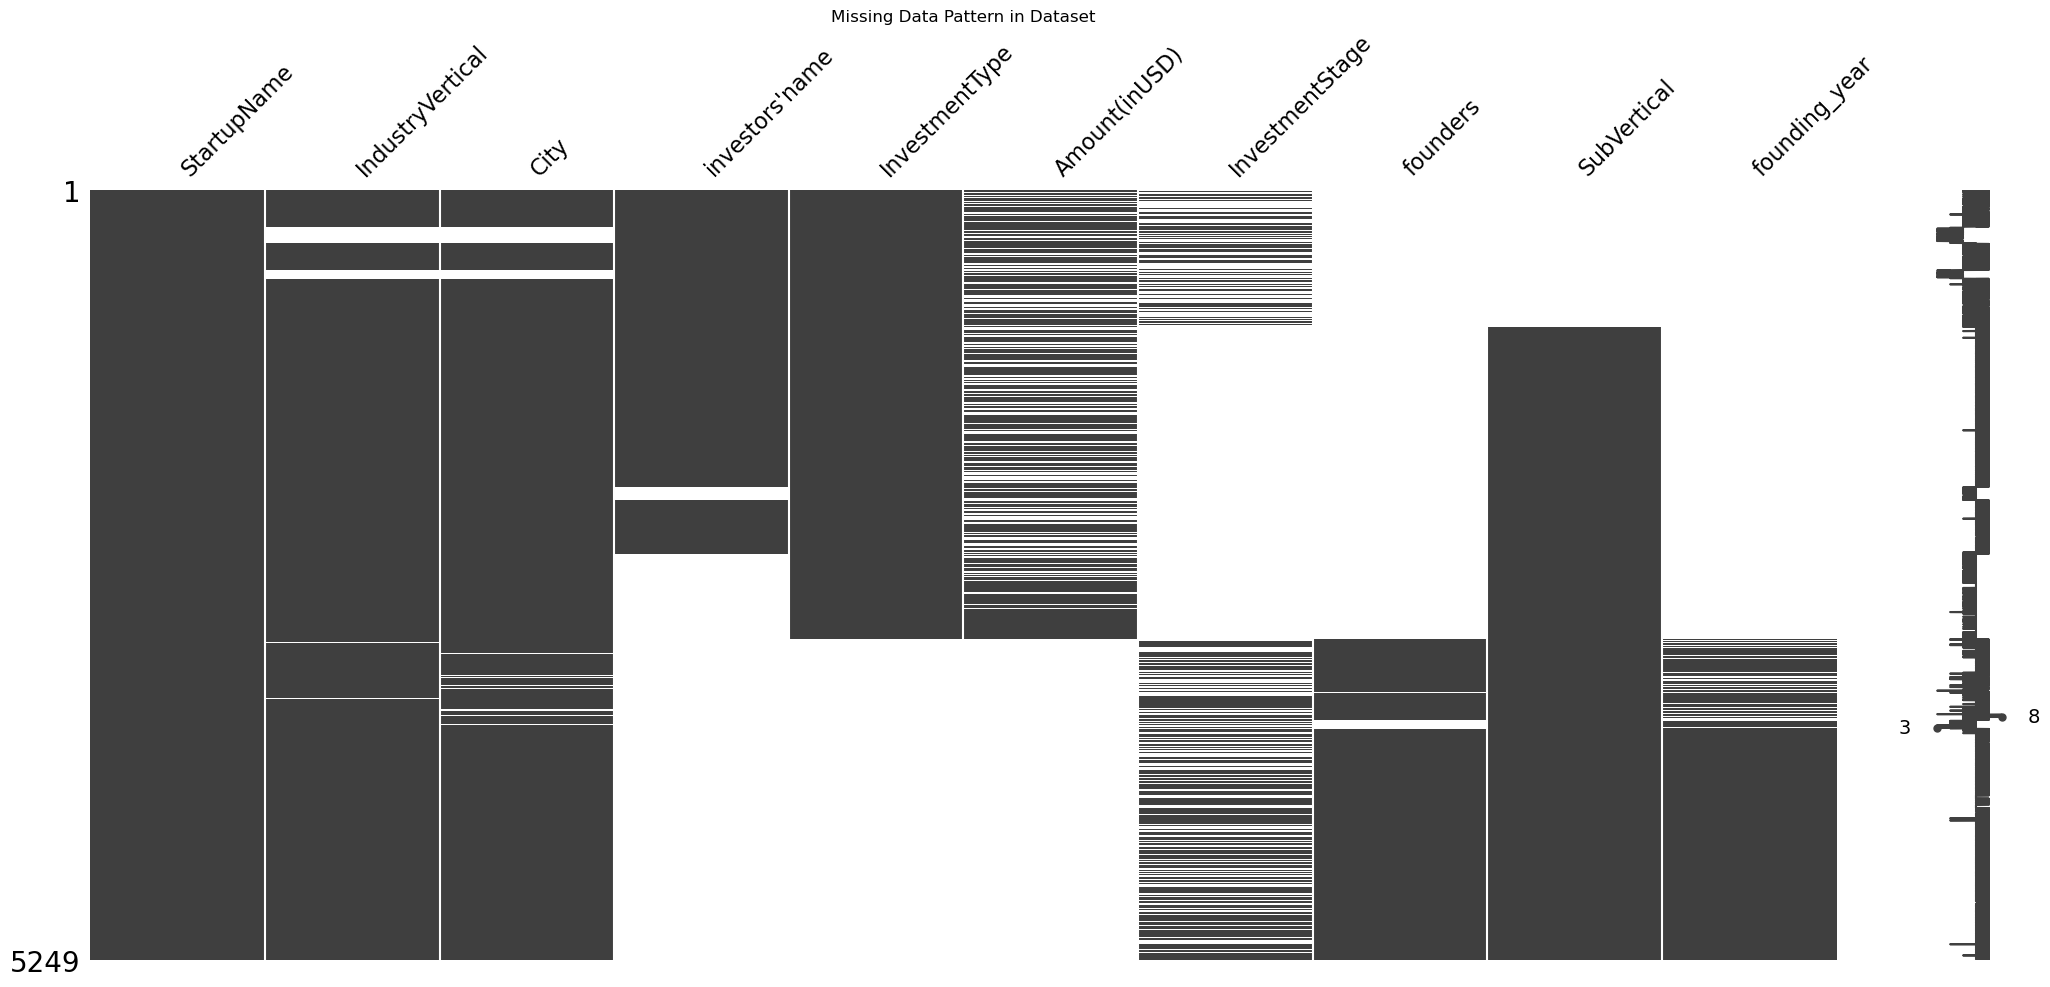

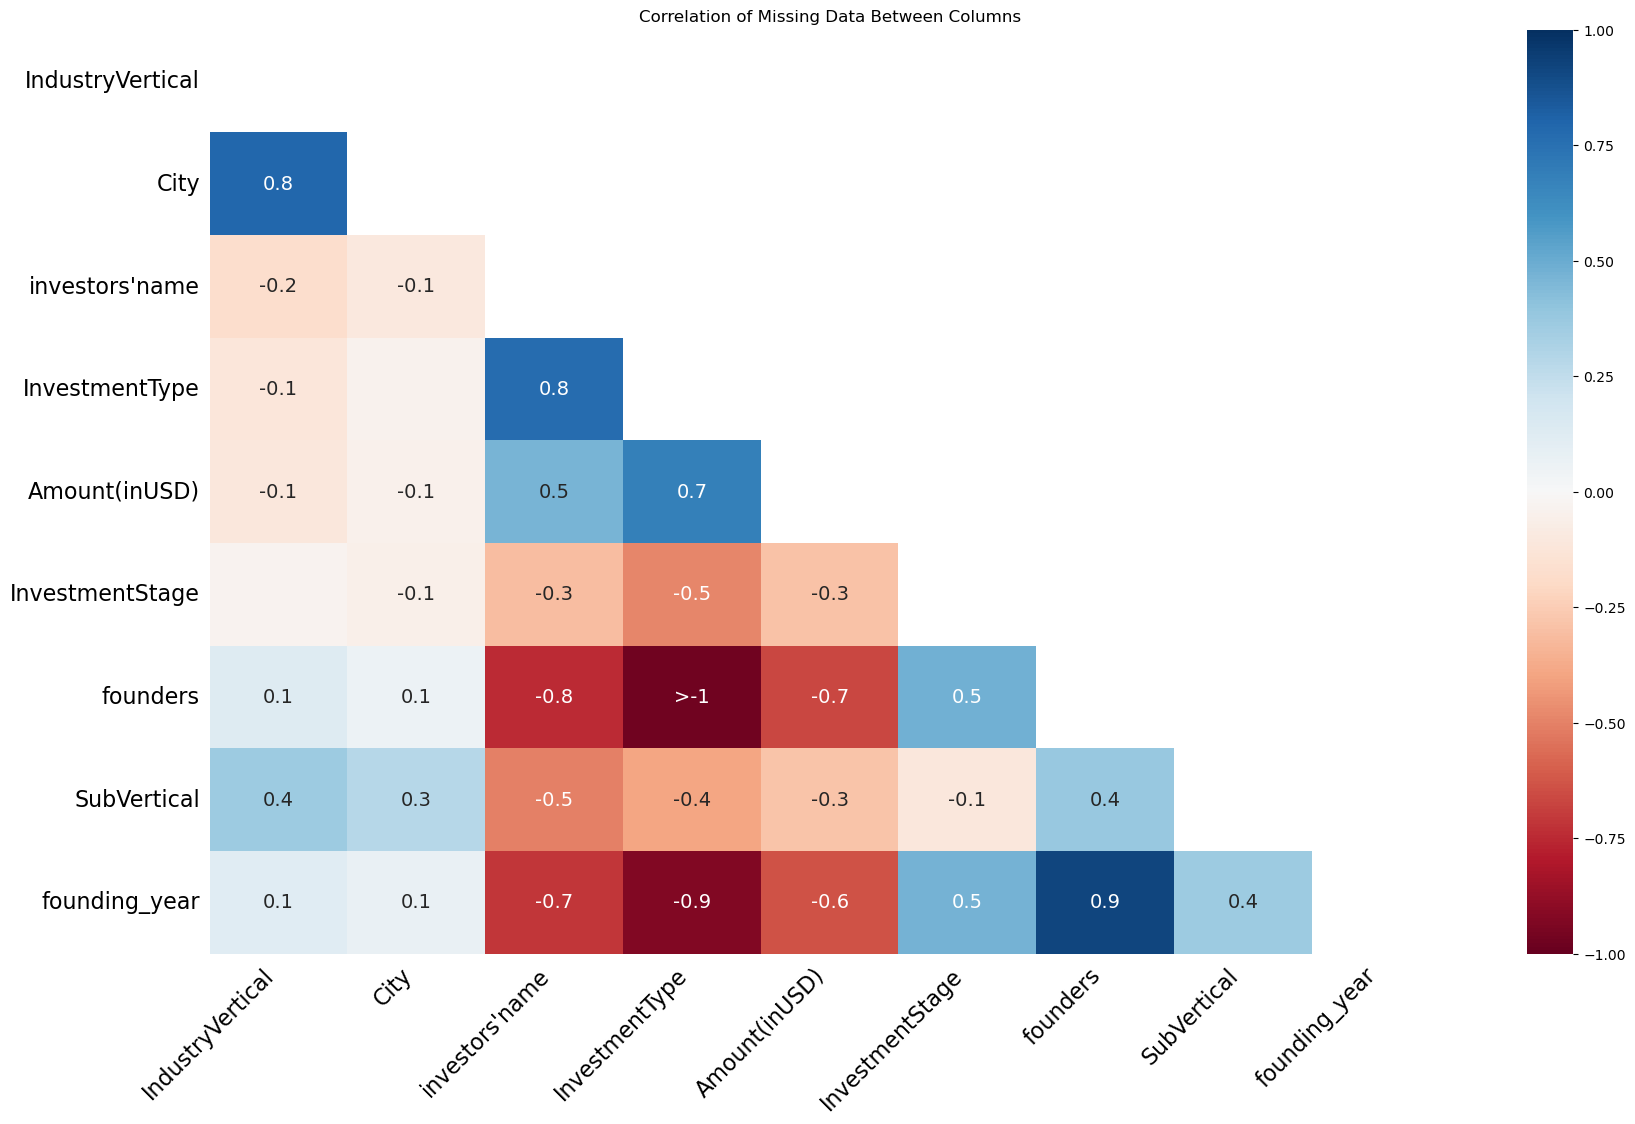

In [31]:
# Visualize missing data patterns
msno.matrix(combined_df)
plt.title('Missing Data Pattern in Dataset')
plt.show()

# Visualize missing data heatmap to show correlations of missingness between different columns
msno.heatmap(combined_df)
plt.title('Correlation of Missing Data Between Columns')
plt.show()

In [32]:
# Duplicate the cleaned dataset as we will need it later
combined_df2=combined_df

In [33]:
# We proceed with imputing missing values. However, we first remove columns that we retain unnecessary for our imputation procedure
combined_df = combined_df.drop(['InvestmentStage', 'investors\'name', 'SubVertical', 'StartupName', 'founders'], axis=1)

In [34]:
# Scale selected features
columns_to_scale = ['Amount(inUSD)', 'founding_year']
scaler = StandardScaler()
combined_df[columns_to_scale] = scaler.fit_transform(combined_df[columns_to_scale])

In [35]:
# We convert 'IndustryVertical', 'City' and 'InvestmentType' into a format suitable for MICE imputation
categorical_columns = ['IndustryVertical', 'City', 'InvestmentType']
for column in categorical_columns:
    combined_df[column] = combined_df[column].astype('category')

In [43]:
kds = mf.ImputationKernel(
    combined_df,
    datasets=10,
    save_all_iterations=False,
    random_state=11
  )
kds.mice(5)

In [39]:
# Initialize an empty list to hold the imputed datasets
imputed_datasets = []

# Assuming you have 5 datasets as in your example
num_datasets = 5

# Loop through the dataset indices and retrieve each one
for i in range(num_datasets):
    imputed_dataset = kds.complete_data(i)
    imputed_datasets.append(imputed_dataset)

In [36]:
# Base directory where the datasets are stored
base_path = "C:\\Bayes Business School\\Digital Technologies & Value Creation\\Datasets\\"

# Number of datasets
num_datasets = 5

# List to hold each dataset
imputed_datasets = []

# Loop to read each dataset into the list
for i in range(1, num_datasets + 1):
    file_path = f"{base_path}imputed_dataset_{i} vel.csv"
    dataset = pd.read_csv(file_path)
    imputed_datasets.append(dataset)

In [37]:
imputed_datasets[2]

,Unnamed: 0,IndustryVertical,City,InvestmentType,Amount(inUSD),founding_year
0,0,Food Services and Platforms,Bengaluru,Private Equity,-0.133622,0.094798
1,1,Specialized Business Services and Others,Gurugram,Seed Funding,-0.148549,-0.167569
2,2,Location Based App,Dallas,Seed Funding,-0.141914,0.488350
3,3,Video Content and Streaming,New Delhi,Seed Funding,-0.149212,0.619534
4,4,Price Comparison,Hyderabad,Seed Funding,-0.148839,0.750718
...,...,...,...,...,...,...
5244,5244,Job Search and Recruitment Platforms,Gurugram,Seed Funding,-0.148922,0.488350
5245,5245,Food Services and Platforms,New Delhi,Private Equity,-0.141914,-0.036385
5246,5246,Financial Technology and Platforms,Bengaluru,Seed Funding,-0.148922,0.488350
5247,5247,Education and EdTech,Gurugram,Series A,-0.134202,-0.036385


In [38]:
 # Drop 'Unnamed: 0' column
for dataset in imputed_datasets:
    dataset.drop('Unnamed: 0', axis=1, inplace=True)

# Now assign the StartupName column to the new DataFrames
for dataset in imputed_datasets:
    dataset['StartupName'] = StartupNameCol
    
# Revert the scaling of the data back to its original distribution and values
for dataset in imputed_datasets:
    dataset[columns_to_scale] = scaler.inverse_transform(dataset[columns_to_scale])

In [40]:
imputed_datasets[3]

,IndustryVertical,City,InvestmentType,Amount(inUSD),founding_year,StartupName
0,Food Services and Platforms,Bengaluru,Private Equity,2000000.00,2015-01-01,Swiggy
1,Specialized Business Services and Others,Gurugram,Seed Funding,200000.00,2020-01-01,Bluegape
2,Location Based App,Dallas,Seed Funding,1000000.00,2015-01-01,KeepTrax
3,Video Content and Streaming,New Delhi,Seed Funding,120000.00,2019-01-01,InstaLively
4,Price Comparison,Hyderabad,Seed Funding,165000.00,2018-01-01,Pricejugaad
...,...,...,...,...,...,...
5244,Job Search and Recruitment Platforms,Gurugram,Seed Funding,120000.00,2019-01-01,Ayu Health
5245,Food Services and Platforms,New Delhi,Seed Funding,1000000.00,2015-01-01,Apna
5246,Financial Technology and Platforms,Bengaluru,Seed Funding,297000.00,2019-01-01,BharatAgri
5247,Education and EdTech,Gurugram,Private Equity,2739034.68,2015-01-01,Flatheads


#### How many unique startups were introduced in year between 2016-2021?


In [41]:
# Initialize a list to store the number of unique startups for each imputed dataset
unique_startup_counts = []

# Iterate over each DataFrame in the list of imputed datasets
for dataset in imputed_datasets:
    dataset['founding_year'] = pd.to_datetime(dataset['founding_year'], format='%Y', errors='coerce')
    # Filter the DataFrame for the years 2016 to 2021
    filtered_data = dataset[dataset['founding_year'].dt.year.isin(range(2017, 2022))]
    
    # Count the number of unique startup names in the filtered data and append to the list
    unique_startup_counts.append(filtered_data['StartupName'].nunique())
print(unique_startup_counts)

[2389, 2331, 2230, 2362, 2439]


#### How has the funding for Indian startups trended over the years?


In [42]:
funding_by_year_results = []

for imputed_data in imputed_datasets:
    # Convert 'founding_year' to datetime type
    imputed_data['founding_year'] = pd.to_datetime(imputed_data['founding_year'], format='%Y', errors='coerce')

    # Summarize funding amounts by year, filtered from 2017 to 2020
    funding_by_year = imputed_data[imputed_data['founding_year'].dt.year.isin(range(2017, 2022))]
    funding_by_year = funding_by_year.groupby(funding_by_year['founding_year'].dt.year)['Amount(inUSD)'].sum().reset_index(name='Total Funding')
    
    funding_by_year_results.append(funding_by_year)

In [43]:
# Combine all results into a single DataFrame for processing
combined_funding_by_year = pd.concat(funding_by_year_results)

# To combine and average funding, group by year across all results
pooled_funding_by_year = combined_funding_by_year.groupby('founding_year')['Total Funding'].mean().reset_index()

c:\Users\Giuse\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Giuse\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


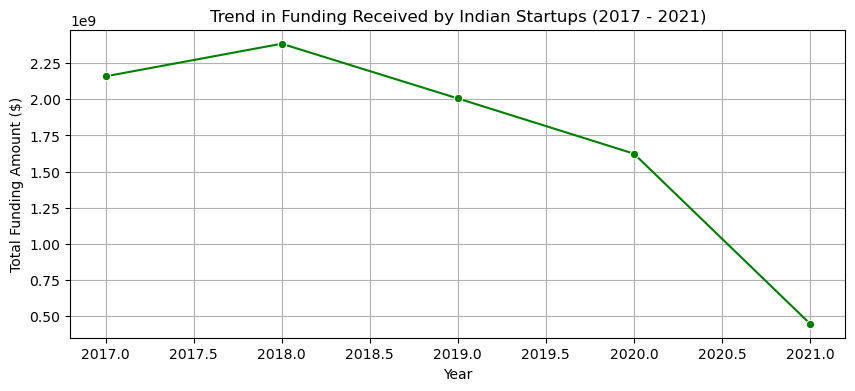

In [44]:
plt.figure(figsize=(10, 4))
sns.lineplot(data=pooled_funding_by_year, x='founding_year', y='Total Funding', marker='o', color='green')
plt.title("Trend in Funding Received by Indian Startups (2017 - 2021)")
plt.xlabel('Year')
plt.ylabel('Total Funding Amount ($)')
plt.grid(True)  # Enable grid for better readability
plt.show()

#### Which sectors have received the most funding between 2016 and 2021?


In [45]:
sector_results = []

for imputed_data in imputed_datasets:
    # Convert 'founding_year' to datetime type
    imputed_data['founding_year'] = pd.to_datetime(imputed_data['founding_year'], format='%Y', errors='coerce')
    
    # Filter the data for the specified years
    filtered_data = imputed_data[imputed_data['founding_year'].dt.year.isin([2017, 2018, 2019, 2020, 2021])]
    
    # Aggregate the funding amounts by sector
    funding_by_sector = filtered_data.groupby('IndustryVertical')['Amount(inUSD)'].sum().reset_index()
    
    sector_results.append(funding_by_sector)

In [46]:
# Combining all the results for further analysis
combined_results_year = pd.concat(sector_results)

# Calculate the mean of the funding amount by sector across all imputed datasets
mean_funding_by_sector = combined_results_year.groupby('IndustryVertical')['Amount(inUSD)'].mean().reset_index()

# Sort and select the top sectors
top_sectors = mean_funding_by_sector.sort_values(by='Amount(inUSD)', ascending=False).head(5)
top_sectors['Amount(inUSD)'] = top_sectors['Amount(inUSD)'] / 1e9  # Convert to billions for readability

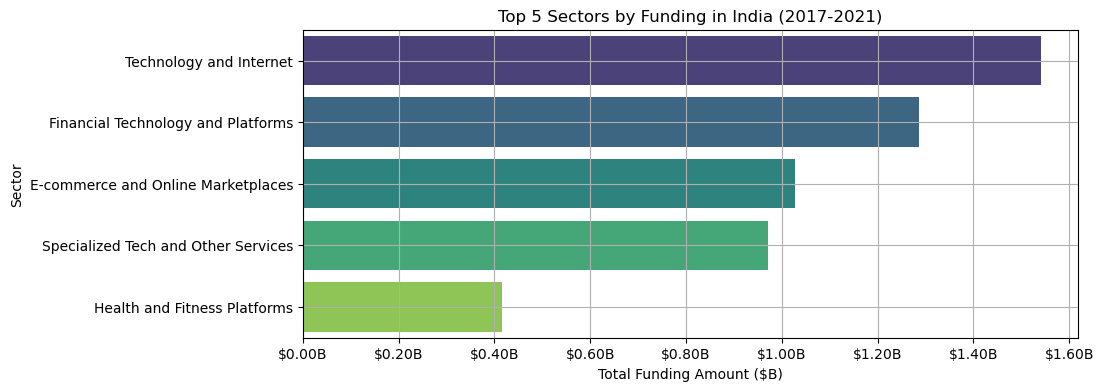

In [47]:
plt.figure(figsize=(10, 4))
sns.barplot(x='Amount(inUSD)', y='IndustryVertical', data=top_sectors, palette='viridis')
plt.gca().xaxis.set_major_formatter('${x:,.2f}B')  # Format as billions with two decimal places
plt.title('Top 5 Sectors by Funding in India (2017-2021)')
plt.xlabel('Total Funding Amount ($B)')
plt.ylabel('Sector')
plt.grid(True)
plt.show()

#### Is there a correlation between the industry sector and funding amounts received by startups, based on their geographical location?


In [48]:
grouped_results = []

for imputed_data in imputed_datasets:
    # Group data by 'IndustryVertical' and 'City'
    grouped_data = imputed_data.groupby(['IndustryVertical', 'City']).agg(
        Total_Funding=('Amount(inUSD)', 'sum'),
        First_Founding_Year=('founding_year', 'min')
    ).reset_index()

    # Store results for each dataset
    grouped_results.append(grouped_data)

In [49]:
# Combine all grouped results into one DataFrame for processing
combined_grouped_data = pd.concat(grouped_results)

# Aggregate the combined data to get total funding per industry and per city across all imputations
total_industry_funding = combined_grouped_data.groupby('IndustryVertical')['Total_Funding'].sum()
total_city_funding = combined_grouped_data.groupby('City')['Total_Funding'].sum()

# Identify top 5 industries and cities based on pooled funding
top_industries = total_industry_funding.nlargest(5).index
top_cities = total_city_funding.nlargest(5).index

# Categorize industries and cities in the original combined data
combined_grouped_data['Industry_grouped'] = combined_grouped_data['IndustryVertical'].apply(
    lambda x: x if x in top_industries else 'Other'
)
combined_grouped_data['City_grouped'] = combined_grouped_data['City'].apply(
    lambda x: x if x in top_cities else 'Other'
)

# Aggregate and prepare data for pivoting
pivot_data = combined_grouped_data.groupby(['City_grouped', 'Industry_grouped'])['Total_Funding'].sum().unstack(fill_value=0)
pivot_data /= 1e9  # Convert 'Total_Funding' from dollars to billions

C:\Users\Giuse\AppData\Local\Temp\ipykernel_16496\2311979177.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


<Figure size 2000x800 with 0 Axes>

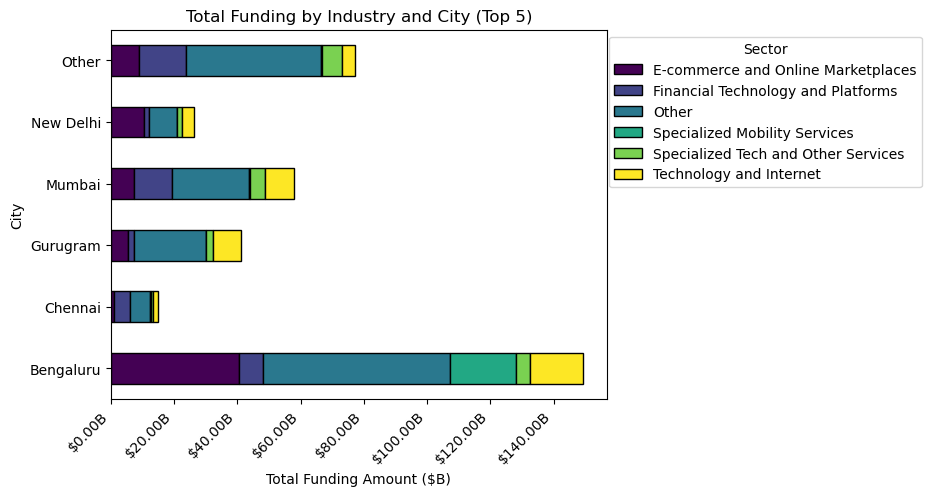

In [50]:
plt.figure(figsize=(20, 8))
ax = pivot_data.plot(kind='barh', stacked=True, colormap='viridis', edgecolor='k')
ax.set_ylabel('City')
ax.set_xlabel('Total Funding Amount ($B)')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_title('Total Funding by Industry and City (Top 5)')
plt.gca().xaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.2f}B'))  # Format as billions with two decimals

# Customize legend
ax.legend(title='Sector', bbox_to_anchor=(0.99, 1), loc='upper left')

plt.show()

#### What are the total funding amounts received by Indian startups across various locations?


In [51]:
city_funding_results = []

for imputed_data in imputed_datasets:
    # Select top 5 industries with highest total funding
    top_industries = imputed_data.groupby('IndustryVertical')['Amount(inUSD)'].sum().nlargest(5).index
    
    # Filter to include only data from these top industries
    df_top_industries = imputed_data[imputed_data['IndustryVertical'].isin(top_industries)]
    
    # Group by city and calculate the total funding for each city
    city_funding = df_top_industries.groupby('City')['Amount(inUSD)'].sum().reset_index()
    city_funding_results.append(city_funding)

In [52]:
# Combining all city funding results
all_city_funding = pd.concat(city_funding_results)

# Calculate the mean funding by city across all imputed datasets
mean_city_funding = all_city_funding.groupby('City')['Amount(inUSD)'].mean().reset_index()

# Sort the results to get top cities
sorted_city_funding = mean_city_funding.sort_values(by='Amount(inUSD)', ascending=False)

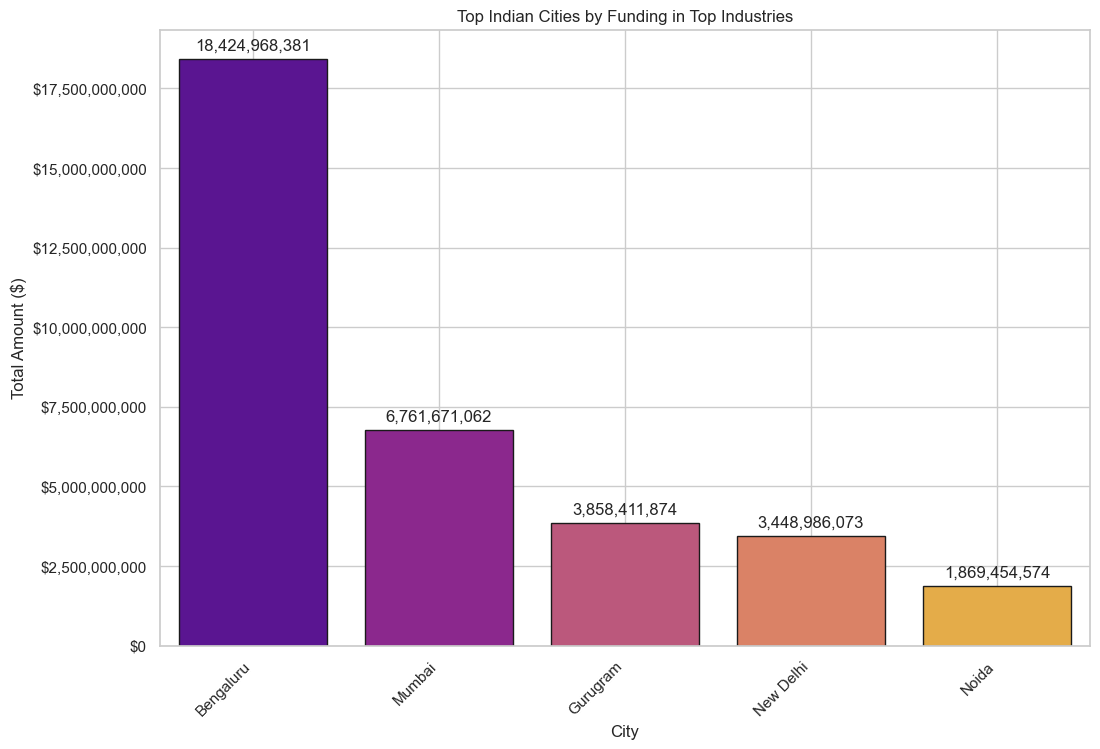

In [53]:
# Select only the top 5 cities
top_5_city_funding = sorted_city_funding.head(5)

plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")
ax = sns.barplot(x='City', y='Amount(inUSD)', data=top_5_city_funding, palette='plasma', edgecolor='k')
ax.set_xlabel('City')
ax.set_ylabel('Total Amount ($)')
ax.set_title('Top Indian Cities by Funding in Top Industries')

# Rotate x-axis labels for better readability
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

ax.grid(True)  # Enabled grid for better readability

# Format y-axis to display currency in dollars
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))

# Add annotations to the bars for exact values
for p in ax.patches:
    ax.annotate(format(p.get_height(), ',.0f'),  # Format the number as a comma-separated string
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')

plt.show()

#### Which 5 companies have secured the most funding?


In [54]:
company_funding_results = []

for imputed_data in imputed_datasets:
    # Calculate total funding for each company
    total_funding = imputed_data.groupby('StartupName')['Amount(inUSD)'].sum()
    company_funding_results.append(total_funding)

In [55]:
# Concatenate the results into a DataFrame for easier manipulation
all_company_funding = pd.concat(company_funding_results, axis=1)

# Calculate the mean funding for each company across all datasets
mean_company_funding = all_company_funding.mean(axis=1)

# Get the top 10 companies based on mean funding
top_5_companies = mean_company_funding.nlargest(5)
top_5_companies /= 1e9  # Convert 'Amount(inUSD)' to billions

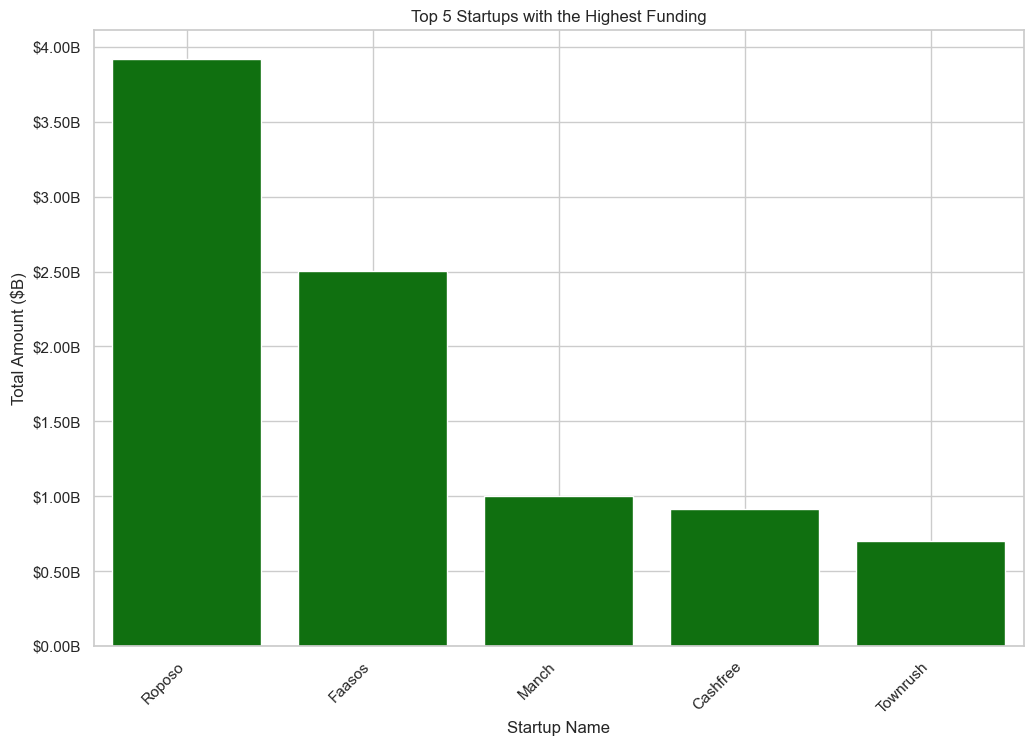

In [56]:
plt.figure(figsize=(12, 8))
ax = sns.barplot(x=top_5_companies.index, y=top_5_companies.values, color='green')
plt.xlabel('Startup Name')
plt.ylabel('Total Amount ($B)')
plt.title('Top 5 Startups with the Highest Funding')
plt.xticks(rotation=45, ha='right')
plt.grid(True)  # Enabled grid for better readability

# Format y-axis ticks to show amounts in billions with 'B' suffix
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.2f}B'))

plt.show()

#### What is the average funding received by Indian startups at various stages of their development?


In [57]:
investment_results = []

for imputed_data in imputed_datasets:
    # Calculate mean funding for each investment type
    mean_funding = imputed_data.groupby('InvestmentType')['Amount(inUSD)'].mean()
    investment_results.append(mean_funding)

In [58]:
# Combine the results into a DataFrame for easier manipulation
all_investment_types = pd.concat(investment_results, axis=1)

# Calculate the mean funding for each investment type across all datasets
pooled_mean_funding = all_investment_types.mean(axis=1)

# Select the top 5 investment types based on the pooled mean funding
top_stage_funding = pooled_mean_funding.nlargest(5)

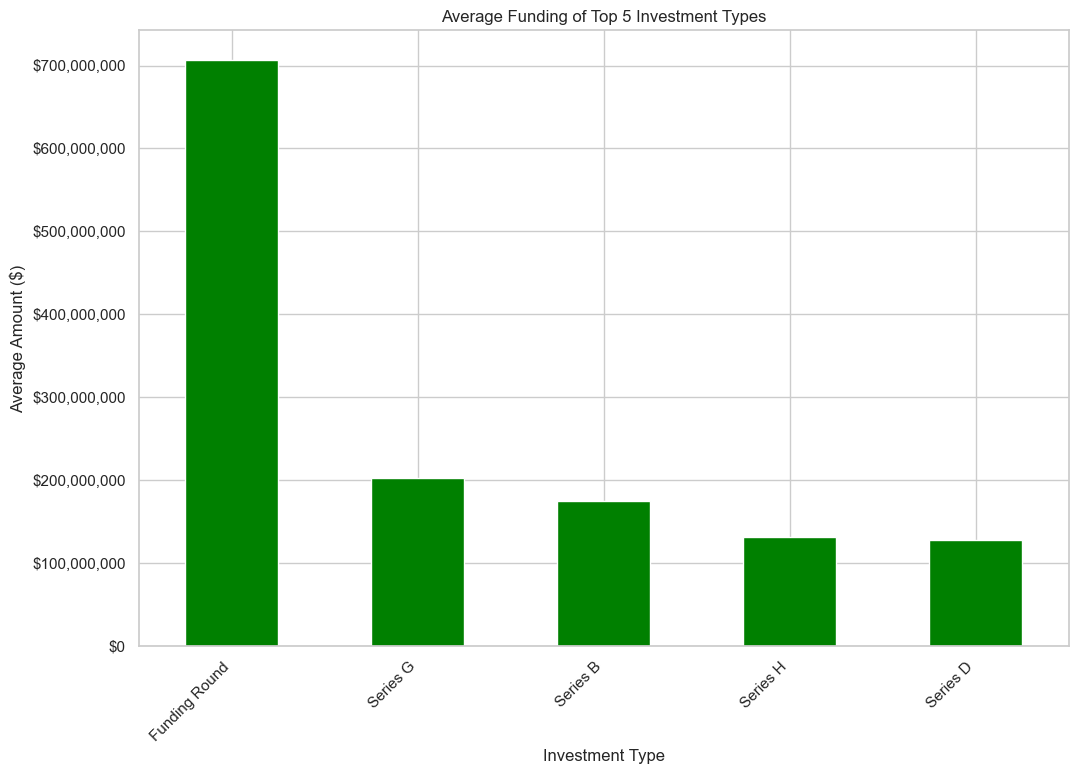

In [59]:
plt.figure(figsize=(12, 8))
ax = top_stage_funding.plot(kind='bar', color='green')
plt.xlabel('Investment Type')
plt.ylabel('Average Amount ($)')
plt.title('Average Funding of Top 5 Investment Types')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.grid(True)  # Enabled grid for better readability

# Formatting y-axis to display currency in dollars
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))

plt.show()

#### Which startups received the most funding annually?


In [60]:
# Filter the data to include only years from 2016 to 2021 and then find the startup with the maximum funding each year
startups_each_year_list = []

for imputed_data in imputed_datasets:
    # Filter for the years 2016 to 2021
    filtered_data = imputed_data[imputed_data['founding_year'].dt.year.isin(range(2017, 2022))]
    
    # Get the index of the startup with the highest funding each year
    max_funding_index = filtered_data.groupby(filtered_data['founding_year'].dt.year)['Amount(inUSD)'].idxmax()
    
    # Get the rows corresponding to the maximum funding
    startup_each_year = filtered_data.loc[max_funding_index]
        
    # Add to the list
    startups_each_year_list.append(startup_each_year)

In [61]:
# Display the startup names for a specific year across all datasets
for year in range(2017, 2022):
    print(f"Year: {year}")
    for i, df in enumerate(startups_each_year_list):
        startup_name = df[df['founding_year'].dt.year == year]['StartupName'].values[0]
        funding = df[df['founding_year'].dt.year == year]['Amount(inUSD)'].values[0]
        print(f"Dataset {i+1}: {startup_name} with ${funding:.2f}")
    print("\n")

Year: 2017
Dataset 1: Groww with $120000000.00
Dataset 2: Little with $17000000.00
Dataset 3: Zenatix with $30000000.00
Dataset 4: Byndr with $23000000.00
Dataset 5: Legalwiz.in with $31000000.00


Year: 2018
Dataset 1: iNICU with $200000000.00
Dataset 2: MedLife with $16000000.00
Dataset 3: Qin1 with $27000000.00
Dataset 4: Dista with $30000000.00
Dataset 5: Nykaa with $32000000.00


Year: 2019
Dataset 1: HandyHome with $60000000.00
Dataset 2: Setu with $16000000.00
Dataset 3: Elanic with $30000000.00
Dataset 4: Zetwerk with $18000000.00
Dataset 5: Innovapptive with $30000000.00


Year: 2020
Dataset 1: POPxo with $87000000.00
Dataset 2: TinyStep with $15000000.00
Dataset 3: Prescinto with $25000000.00
Dataset 4: Printvenue with $25000000.00
Dataset 5: Oyo with $31000000.00


Year: 2021
Dataset 1: XYXX Apparels with $63000000.00
Dataset 2: Trukky with $155000.00
Dataset 3: Fi with $17411265.00
Dataset 4: IGL with $25000000.00
Dataset 5: Paytm with $15109500.00




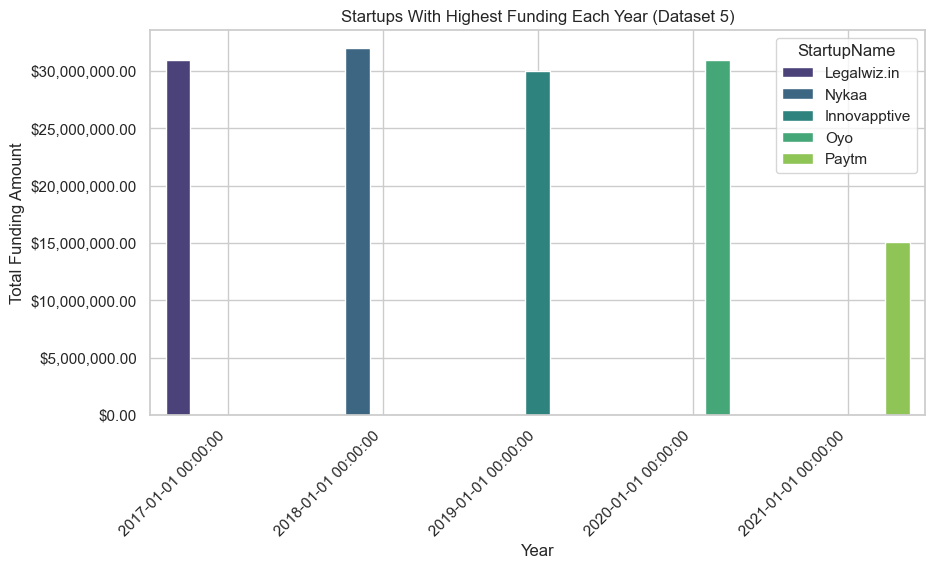

In [64]:
# Visualizing data from one of the datasets (for example, the first one)
plt.figure(figsize=(10, 5))
ax = sns.barplot(x='founding_year', y='Amount(inUSD)', hue='StartupName', data=startups_each_year_list[4], palette='viridis')
plt.xlabel('Year')
plt.ylabel('Total Funding Amount')
plt.title('Startups With Highest Funding Each Year (Dataset 5)')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.grid(True)  # Enabled grid for better readability
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.2f}'))

plt.show()

#### Are there any patterns in the location of a company and the amount of funding it receives?

In [65]:
city_funding_results = []
company_occurrences = []

for imputed_data in imputed_datasets:
    # Calculate total funding for each city
    city_funding = imputed_data.groupby('City')['Amount(inUSD)'].sum().reset_index()

    # Get the top 10 cities by total funding
    top_cities = city_funding.nlargest(10, 'Amount(inUSD)')

    # Filter to include only the top cities
    df_top_cities = imputed_data[imputed_data['City'].isin(top_cities['City'])].copy()  # Use .copy() to avoid SettingWithCopyWarning

    # Find the top 10 companies by occurrence within the top cities
    top_companies = df_top_cities['StartupName'].value_counts().nlargest(10).index

    # Keep a record of company occurrences and the filtered DataFrame for top cities
    company_occurrences.append(df_top_cities['StartupName'].value_counts().nlargest(10))
    city_funding_results.append(df_top_cities)   

In [66]:
# Combine city funding results
combined_city_funding = pd.concat(city_funding_results)

# Pool the total funding amounts by city
mean_city_funding = combined_city_funding.groupby(['City', 'StartupName'])['Amount(inUSD)'].mean().reset_index()

# Summing occurrences across all datasets to find the most frequent top companies
total_occurrences = pd.concat(company_occurrences, axis=1).sum(axis=1).nlargest(10)

# Filter the combined DataFrame for the top companies
df_top_locations_top_companies = combined_city_funding[combined_city_funding['StartupName'].isin(total_occurrences.index)].copy() 
df_top_locations_top_companies['Amount(inUSD)'] = df_top_locations_top_companies['Amount(inUSD)'] / 1e9  # Convert to billions safely on a copy

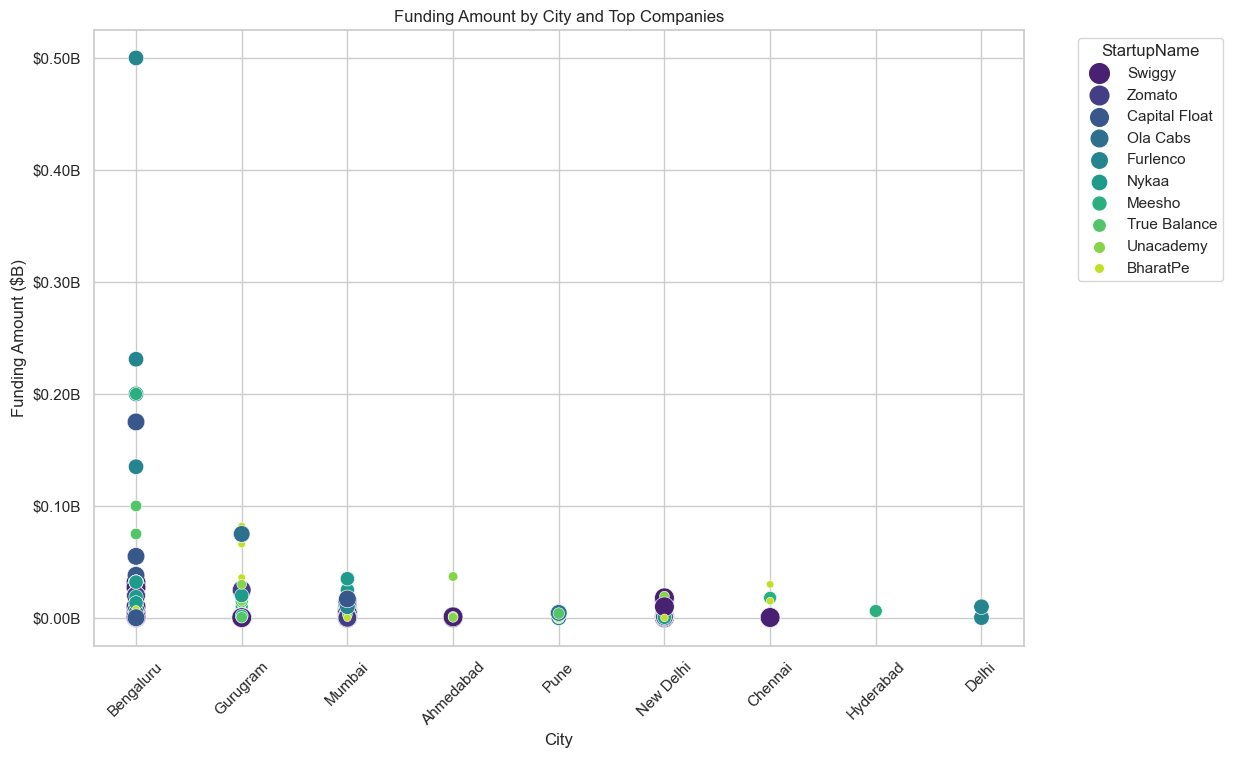

In [67]:
plt.figure(figsize=(12, 8))
ax = sns.scatterplot(x='City', y='Amount(inUSD)', hue='StartupName', data=df_top_locations_top_companies, palette='viridis', size='StartupName', sizes=(30, 200))
plt.xlabel('City')
plt.ylabel('Funding Amount ($B)')
plt.title('Funding Amount by City and Top Companies')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Format y-axis to display currency in billions with 'B' suffix
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.2f}B'))

plt.grid(True)  # Enabled grid for better readability
plt.legend(title='StartupName', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

#### Are there any trends between the location of a company and the funding it receives? 

To explore the relationship between a company's location and the funding it receives, we can frame our investigation around the following hypotheses:

Null Hypothesis (H0): The amount of funding received by startups in India is not associated with their geographic location.

Alternative Hypothesis (Ha): The amount of funding received by startups in India is associated with their geographic location.

I will do this by comparing the city with the most funding activity alone Bengaluru, with a group of other cities that are Gurugram, Mumbai and Ahmedabad.

In [65]:
# Initialize lists to store data
Bengaluru_group = []
Other_group = []

# Iterate over each DataFrame in your list of imputed datasets
for dataset in imputed_datasets:
    # Extract funding amounts for Bengaluru
    Bengaluru_data = dataset[dataset['City'] == 'Bengaluru']['Amount(inUSD)'].dropna()
    Bengaluru_group.append(pd.to_numeric(Bengaluru_data, errors='coerce'))
    
    # Extract funding amounts for the other specified cities
    other_data = dataset[dataset['City'].isin(['Gurugram', 'Mumbai', 'Ahmedabad'])]['Amount(inUSD)'].dropna()
    Other_group.append(pd.to_numeric(other_data, errors='coerce'))

# Combine all results into a single Series for each group
combined_Bengaluru_data = pd.concat(Bengaluru_group, ignore_index=True)
combined_other_data = pd.concat(Other_group, ignore_index=True)

To test our hypothesis we need first to check the distribution of our data

c:\Users\Giuse\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Giuse\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


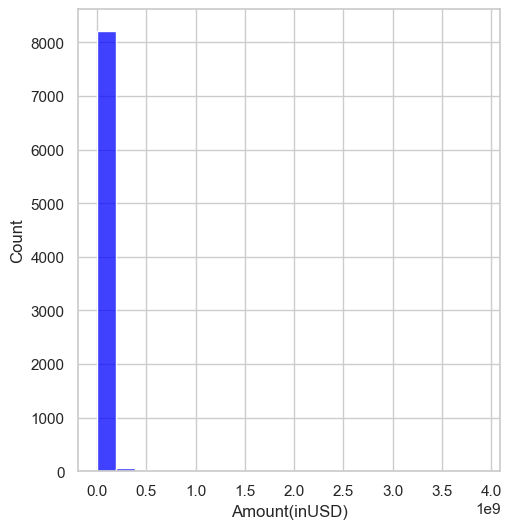

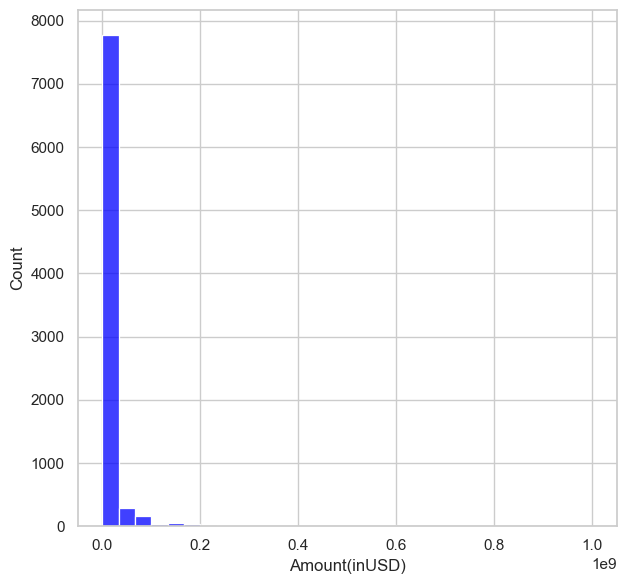

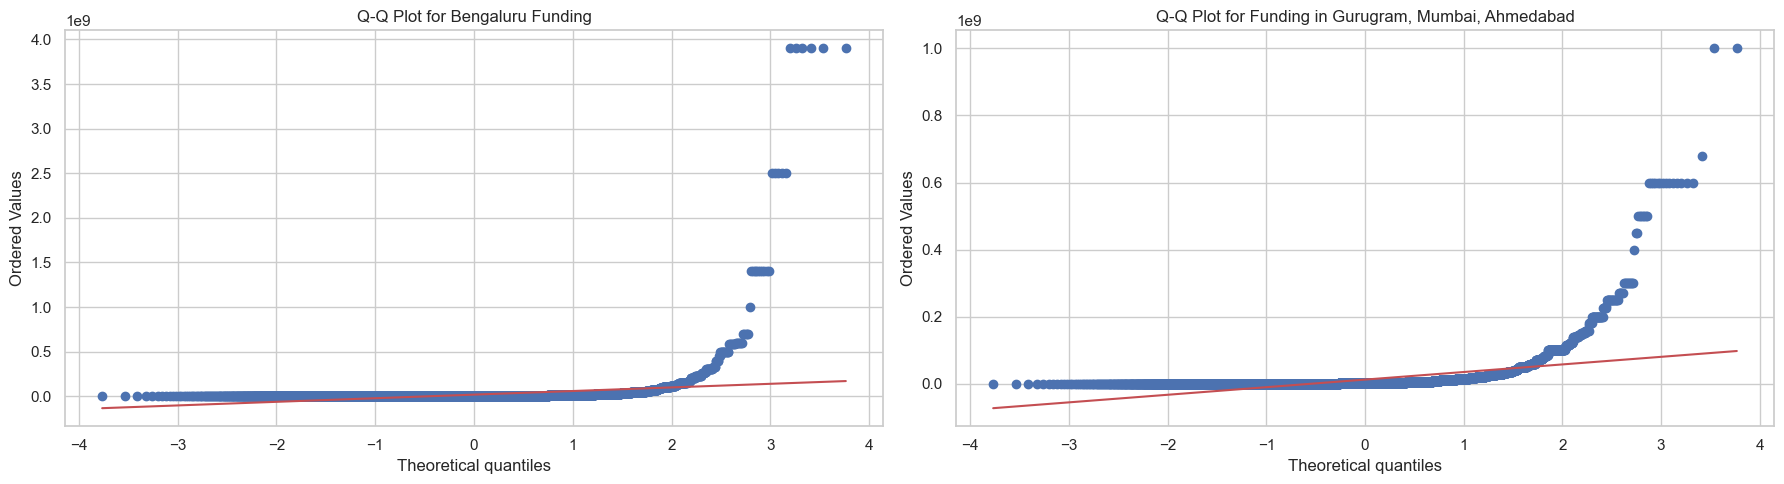

In [66]:
# Calculate the range of your data
data_range = np.max(combined_Bengaluru_data) - np.min(combined_Bengaluru_data)

# Choose an approximate number of bins you want (for example, 30)
num_bins = 20

# Calculate the bin width
bin_width = data_range / num_bins

# Plotting histogram 
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(combined_Bengaluru_data, bins=int(num_bins), color='blue')

# Histogram for other cities data
data_range2 = np.max(combined_other_data) - np.min(combined_other_data)
num_bins2 = 30
bin_width2 = data_range2 / num_bins2

# Plotting histogram 
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(combined_other_data, bins=int(num_bins2), color='blue')

# Show the plot
plt.tight_layout()
plt.show()

# Q-Q Plots
plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 1)
stats.probplot(combined_Bengaluru_data.dropna(), dist="norm", plot=plt)
plt.title('Q-Q Plot for Bengaluru Funding')

plt.subplot(1, 2, 2)
stats.probplot(combined_other_data.dropna(), dist="norm", plot=plt)
plt.title('Q-Q Plot for Funding in Gurugram, Mumbai, Ahmedabad')

plt.tight_layout()
plt.show()

The plots show that the higher quantiles of the funding data are much larger than what would be expected if the data were normally distributed. There is a clustering of points at the lower end of the scale, indicating that a large number of startups have received relatively small amounts of funding. The points that veer off from the red line at the high end represent extreme values or outliers. These are startups that have received exceptionally high funding compared to others.

In [67]:
# Combine all results into a single Series for each group
combined_Bengaluru_data = pd.concat(Bengaluru_group, ignore_index=True)
combined_other_data = pd.concat(Other_group, ignore_index=True)

# Perform the Mann-Whitney U test
stat, p = stats.mannwhitneyu(combined_Bengaluru_data, combined_other_data, alternative='two-sided')

In [68]:
print("Mann-Whitney U test result (U-statistic, p-value):", stat, p)

if p < 0.05:
    print('Significant differences exist between the groups: Funding amounts are affected by the city.')
else:
    print('No significant differences found: Funding amounts are not dependent on the city.')

Mann-Whitney U test result (U-statistic, p-value): 36241702.0 0.00011402457060472047
Significant differences exist between the groups: Funding amounts are affected by the city.


# Does funding depends upon number of investors?

To proceed with our analysis, we notice that  various startups have multiple number of investors. Thus, sice various startups have multiple number of investors, we will arrange according to the number of investors for a particular startup (startup name). 

In [ ]:
def calculate_n_investors(x):
    if x == 'empty':
        return 0
    return x.count(',') + 1 if ',' in x else 1

In [ ]:
combined_df2['investors\'name'] = combined_df2['investors\'name'].replace(np.NaN, 'empty')
combined_df2['NO._of_Investors'] = combined_df2['investors\'name'].apply(calculate_n_investors)

# Normalize and split investors into a list
NO_of_Investors = combined_df2['investors\'name'].fillna('None').str.lower().str.strip().str.split(',')

# Flatten the list of lists into a single list and remove 'none' or empty strings
investors = [investor.strip() for sublist in NO_of_Investors for investor in sublist if investor and investor != 'none']

# Deduplicate investors
unique_investors = list(set(investors))

# Create pandas Series from the lists for easier manipulation
investors_series = pd.Series(investors)
unique_investors_series = pd.Series(unique_investors)

# Further cleaning to remove any residual empty strings
investors_cleaned = investors_series[investors_series != '']
unique_investors_cleaned = unique_investors_series[unique_investors_series != '']

In [ ]:
# Build a mapping from possible variations to the canonical names
name_mapping = {variant: canonical for canonical in unique_investors_cleaned for variant in unique_investors_cleaned if re.search(canonical, variant)}

# Apply this mapping
investors_final = investors_cleaned.map(name_mapping).fillna(investors_cleaned)

In [ ]:
imputed_data['NO._of_Investors']= combined_df2['NO._of_Investors']

How many investors?

In [ ]:
print(imputed_data['NO._of_Investors'].nunique())

11


In [ ]:
# Now assign the StartupName column to the new DataFrames
for dataset in imputed_datasets:
    dataset['investors\'name'] = StartupNameCol

In [ ]:
def calculate_investor_funding(df):
    # Assuming df is the DataFrame with investor names split and cleaned
    # and 'AmountInUSD' correctly formatted and filled for missing values
    d = dict()
    for i in unique_investors:  # Ensure unique_investors is defined as the list of all unique investors
        for j in range(len(df)):
            listed_n_inv = df['investors\'name'][j].split(',')  # Splitting investors if not already split
            if i in listed_n_inv:
                if df['AmountInUSD'][j] is not None and len(listed_n_inv) > 0:
                    amount = df['AmountInUSD'][j] / len(listed_n_inv)
                    if i in d:
                        d[i] += amount
                    else:
                        d[i] = amount
    
    Investor_amount = pd.Series(d, name='Amount').reset_index()
    Investor_amount.columns = ["Investor", "Amount"]
    return Investor_amount

# Assuming 'imputed_datasets' is a list of DataFrames, each one an imputed dataset
all_investor_data = []

for dataset in imputed_datasets:
    all_investor_data.append(calculate_investor_funding(dataset))

KeyError: "investors'name"

In [ ]:
print(dataset.columns)


Index(['IndustryVertical', 'City', 'InvestmentType', 'Amount(inUSD)',
       'founding_year', 'StartupName'],
      dtype='object')


In [ ]:
d=dict()#to store individual investors and funding amount in key-value pairs
for i in unique_investors:
    for j in range(len(listed_n_inv)):
        if i in listed_n_inv[j]:
            d[i]=newdf['AmountInUSD'][j]/len(listed_n_inv[j])#taking average of amount 

In [ ]:
Investor_amount=pd.Series(d,name='Amount')

Investor_amount=show(Investor_amount,).reset_index().groupby('index').sum()['Amount'].sort_values(ascending=False).head(100)
Investor_amount=show(Investor_amount).reset_index()
Investor_amount.columns=["Investor","Amount"]

In [ ]:
print('Top 10 Most funded Investors')
plt.figure(figsize=(12,7))
sns.barplot(y='Investor',x='Amount',data=Investor_amount.head(10))
print(Investor_amount.head(10))
plt.show()